## **Authors**:
- AFAQ Ahzam
- EL OTMANI Youssef
- GUPTE Jay Saumil


The link to the dataset:
[Kaggle Link](https://www.kaggle.com/datasets/mexwell/employee-performance-and-productivity-data?resource=download)

# **Employee Performance Classification**

## **Necessary Libraries**

In [2]:
!pip install imblearn

In [3]:
!pip install seaborn

In [4]:
!pip install xgboost

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, recall_score, roc_auc_score)
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## **About the Data**

### Overview

This dataset contains **100,000 employee records** capturing demographic attributes, job characteristics, productivity indicators, and performance outcomes within a corporate environment. The data is structured for analytical tasks related to workforce management, including performance modeling, productivity assessment, churn prediction, and general HR analytics.

The dataset integrates both **static features** (e.g., education level, job title) and **dynamic behavioral indicators** (e.g., overtime hours, remote work frequency), making it suitable for machine learning applications such as classification, segmentation, and predictive modeling.

---

### Feature Dictionary

### 1. Employee Identifiers & Demographics

* **Employee_ID**
  Unique numerical identifier for each employee.

* **Gender**
  Categorical variable indicating gender (Male, Female, Other).

* **Age**
  Age of the employee, ranging from 22 to 60.

* **Education_Level**
  Highest academic qualification achieved:
  *High School, Bachelor, Master, PhD.*

---

### 2. Job & Career Attributes

* **Department**
  Functional department (e.g., Sales, HR, IT).

* **Job_Title**
  Official job role (e.g., Analyst, Developer, Manager).

* **Hire_Date**
  Date of joining the company.

* **Years_At_Company**
  Tenure calculated from the hire date.

* **Promotions**
  Count of promotions received during tenure.

---

### 3. Performance & Compensation

* **Performance_Score**
  Performance rating on a **1–5 scale** (primary target in classification tasks).

* **Monthly_Salary**
  Monthly compensation in USD.
  Salary is correlated with both job title and performance.

* **Employee_Satisfaction_Score**
  Self-reported satisfaction rating from **1.0 to 5.0**.

---

### 4. Productivity & Work Habits

* **Work_Hours_Per_Week**
  Average weekly work hours.

* **Projects_Handled**
  Total number of projects managed by the employee.

* **Overtime_Hours**
  Number of overtime hours accumulated over the past year.

* **Training_Hours**
  Hours spent in professional training programs.

* **Remote_Work_Frequency**
  Percentage of time working remotely:
  *0%, 25%, 50%, 75%, or 100%.*

* **Team_Size**
  Number of team members directly associated with the employee.

---

### 5. Attendance & Churn Indicators

* **Sick_Days**
  Number of sick days taken annually.

* **Resigned**
  Boolean label indicating whether the employee eventually resigned (0 = stayed, 1 = resigned).

---

### 6. Potential Use Cases

This dataset is well-suited for **employee churn prediction**, as it contains several behavioral, performance-related, and demographic indicators that typically precede resignation. Variables such as overtime hours, satisfaction scores, tenure, promotion history, and remote-work frequency can be used to build models that identify employees at high risk of leaving. This enables proactive retention strategies and gives HR teams an evidence-based foundation for intervention planning.

It is also useful for **productivity analysis**, since features like work hours, projects handled, overtime, training investment, and team size collectively describe employee output and work patterns. By examining how these attributes relate to measurable performance or project involvement, the dataset allows for detailed modeling of the drivers of productivity. This supports decisions around workload distribution, job design, and resource allocation.

A third application is **performance evaluation**, where the goal is to understand what factors correlate with higher performance scores. Because the dataset includes compensation, education level, experience, job role, satisfaction ratings, and behavioral metrics, one can build interpretable or predictive models to explain or estimate performance. This is valuable for designing fairer appraisal systems, identifying high-impact training programs, and refining promotion criteria.

Finally, the dataset provides a solid foundation for broader **HR analytics**. With comprehensive information on demographics, job characteristics, work behavior, satisfaction, and outcomes, it supports organizational-level assessments such as workforce segmentation, diversity analysis, promotion trends, and department-level comparisons. These insights enable strategic planning, policy evaluation, and evidence-driven decision-making across the HR pipeline.



## **Data Loading and EDA**

In [8]:
print("\n" + "="*80)
print("SECTION I: DATA LOADING + CLEANING")
print("="*80)

np.random.seed(42)
df = pd.read_csv('./data.csv')

print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

# Basic statistics
print(f"\nDataset info:")
print(df.info())

# Check class distribution
print(f"\nOriginal class distribution:")
print(df['Performance_Score'].value_counts().sort_index())
print(f"\nClass proportions:")
print(df['Performance_Score'].value_counts(normalize=True).sort_index())

# Outlier detection per class
print(f"\nNumeric feature statistics by Performance Score:")
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('Performance_Score')
for col in numeric_cols[:3]:
    print(f"\n{col}:")
    print(df.groupby('Performance_Score')[col].describe())


SECTION I: DATA LOADING + CLEANING

Dataset shape: (100000, 20)

First few rows:
   Employee_ID        Department  Gender  Age   Job_Title  \
0            1                IT    Male   55  Specialist   
1            2           Finance    Male   29   Developer   
2            3           Finance    Male   55  Specialist   
3            4  Customer Support  Female   48     Analyst   
4            5       Engineering  Female   36     Analyst   

                    Hire_Date  Years_At_Company Education_Level  \
0  2022-01-19 08:03:05.556036                 2     High School   
1  2024-04-18 08:03:05.556036                 0     High School   
2  2015-10-26 08:03:05.556036                 8     High School   
3  2016-10-22 08:03:05.556036                 7        Bachelor   
4  2021-07-23 08:03:05.556036                 3        Bachelor   

   Performance_Score  Monthly_Salary  Work_Hours_Per_Week  Projects_Handled  \
0                  5          6750.0                   33            

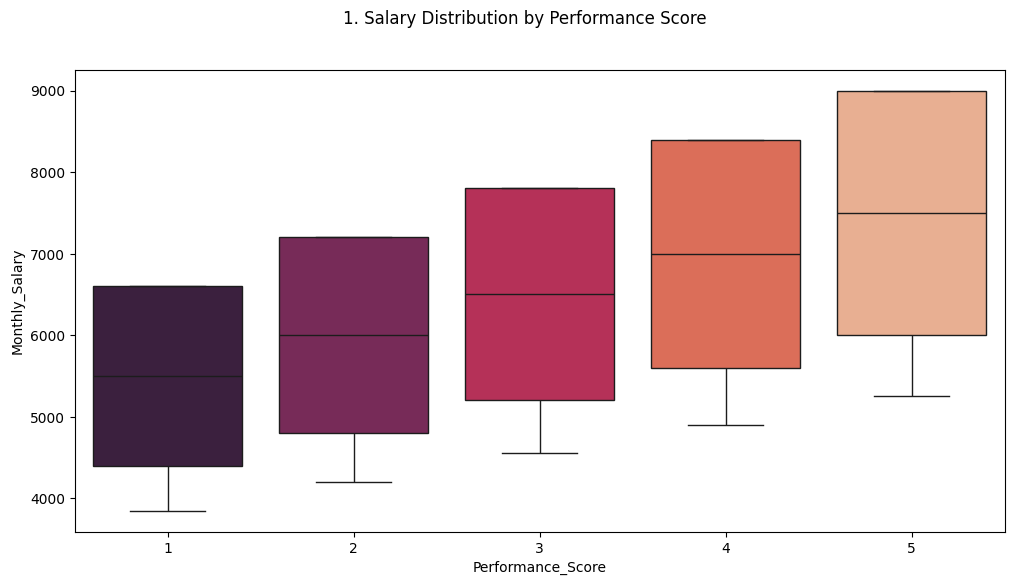

In [9]:

# 1. SALARY (Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Performance_Score', y='Monthly_Salary', data=df, palette='rocket')
plt.suptitle("1. Salary Distribution by Performance Score")
plt.show()


## Salary vs Performance Score

- Salaries increase steadily with higher performance scores, with both median and spread shifting upward from score 1 to 5, confirming a strong positive link between pay and ratings.  
- Lower scores (1–2) show narrower ranges and lower medians, while employees with scores 4–5 earn significantly more and exhibit wider variation, likely reflecting senior or high‑impact roles.  
- This pattern supports the idea that the target variable (Performance_Score) is meaningfully related to Monthly_Salary and can be a useful signal in the classification model.  



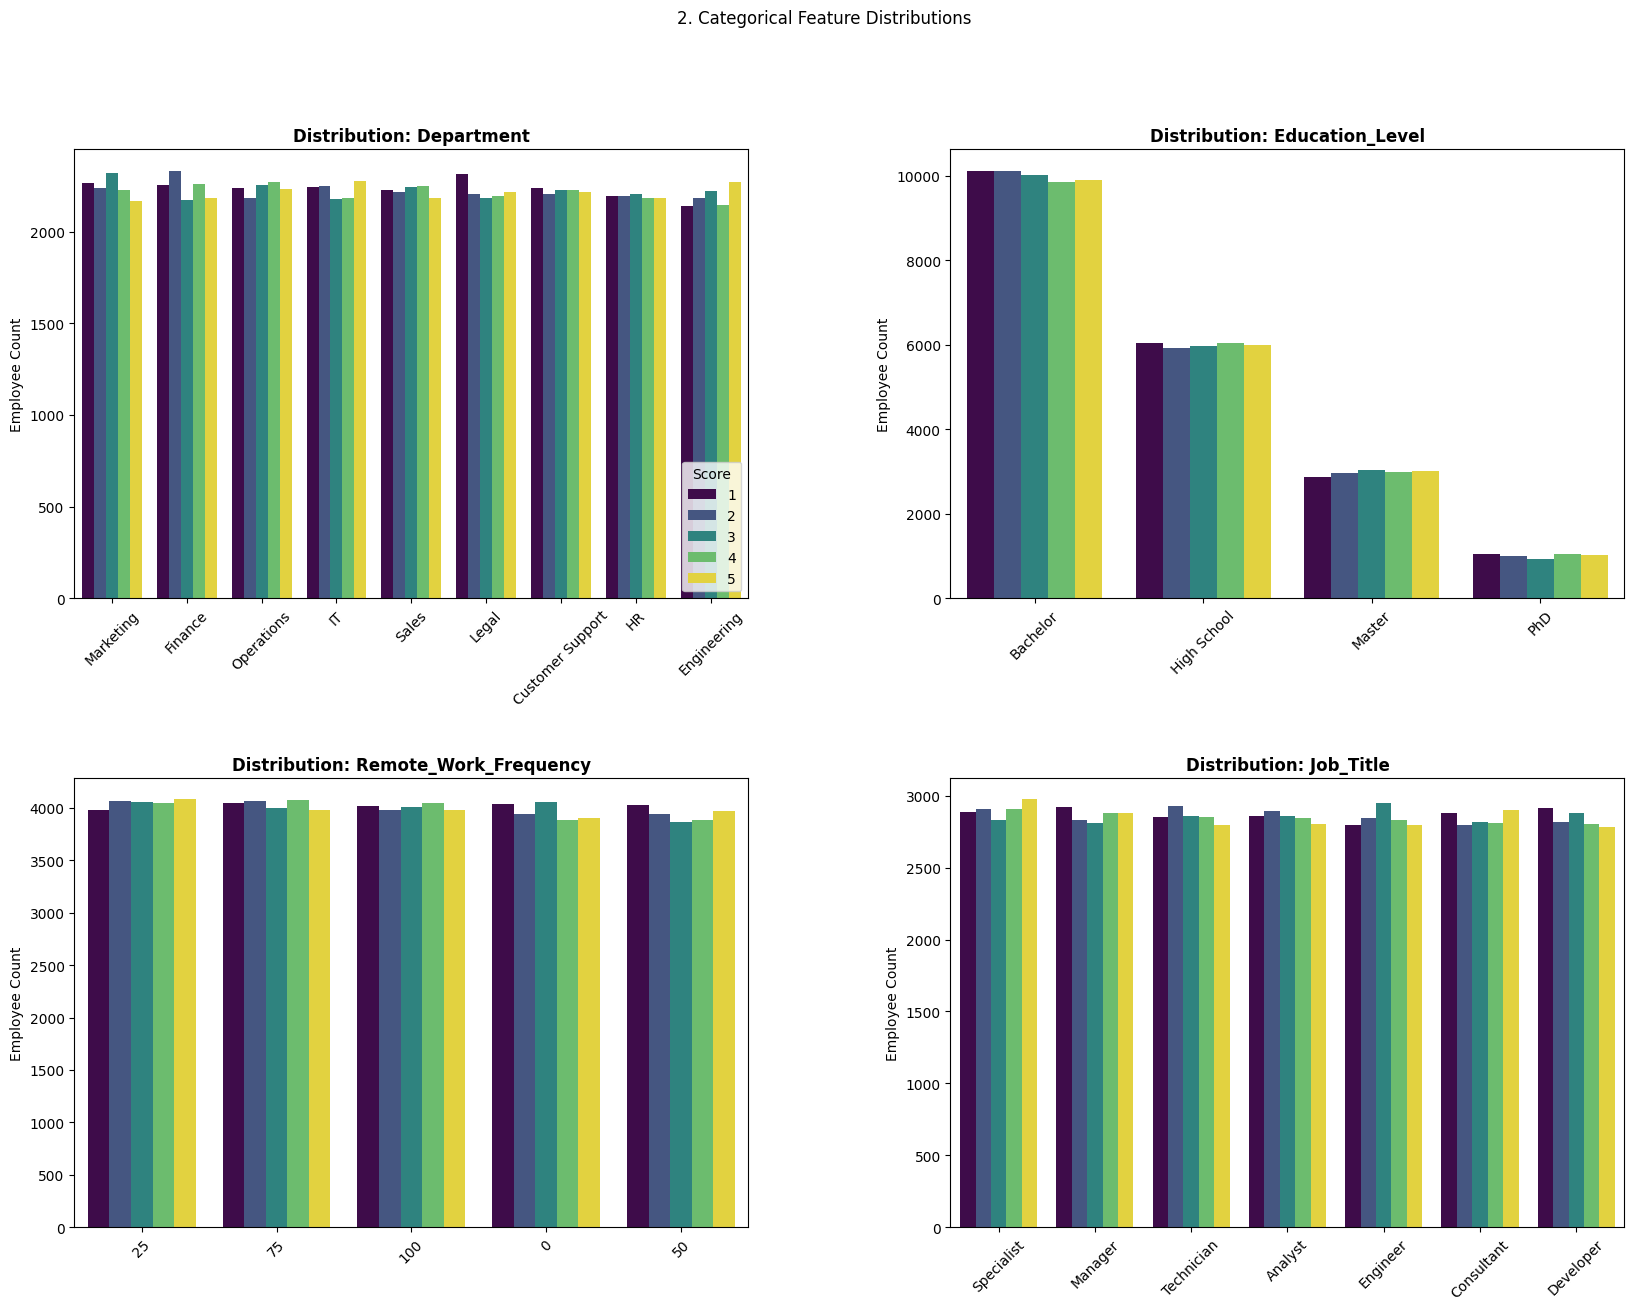

In [10]:
# 2. CATEGORICAL FEATURES
cat_features = ['Department', 'Education_Level', 'Remote_Work_Frequency', 'Job_Title']

fig, axes = plt.subplots(2, 2, figsize=(20, 14))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
axes = axes.flatten()

for i, col in enumerate(cat_features):
    ax = axes[i]

    top_categories = df[col].value_counts().nlargest(10).index #since Job_Title has too many categories

    sns.countplot(data=df[df[col].isin(top_categories)], x=col, hue='Performance_Score',
                  palette='viridis', ax=ax, order=top_categories)

    ax.set_title(f'Distribution: {col}', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')
    ax.set_ylabel("Employee Count")
    if i == 0:
        ax.legend(title='Score', loc='lower right')
    else:
        ax.get_legend().remove()

plt.suptitle("2. Categorical Feature Distributions")
plt.show()


## Distribution by Department

- The employee count in each department is fairly balanced across performance scores, with no department showing a strong skew toward very high or very low ratings.  
- This suggests performance is evaluated relatively uniformly across functional areas such as Marketing, Finance, IT, Sales, and others, reducing department‑specific bias in the target.  
- Because the class proportions remain similar within departments, Department is more likely to act as a mild contextual feature rather than a dominant driver of performance predictions.  

## Distribution by Education Level

- Bachelor’s and High School graduates form the largest share of the workforce at every performance score, while Master’s and PhD holders are fewer across all classes.  
- Performance scores appear relatively evenly spread within each education level, indicating that higher education does not guarantee higher ratings in this dataset.  
- Education_Level is therefore useful to capture background differences but may not be a primary discriminator between performance classes, especially at the top scores.  

## Distribution by Remote Work Frequency

- Employee counts are broadly similar across remote work levels (0%, 25%, 50%, 75%, 100%) for each performance score, indicating no strong preference of high performers toward a specific remote frequency.  
- The absence of a clear monotonic pattern suggests that remote work policy does not heavily influence performance ratings at scale in this organization.  
- Remote_Work_Frequency may still contribute subtle interactions with other variables (like job role or workload) but is unlikely to be a stand‑alone predictor of performance class.  

## Distribution by Job Title

- Each job title (e.g., Specialist, Manager, Technician, Analyst, Engineer, Consultant, Developer) shows relatively comparable counts across performance scores, with no title dominated by a single rating.  
- This balance implies that the performance evaluation system treats roles consistently, without over‑rewarding or penalizing specific titles.  
- Job_Title will primarily encode salary band and responsibility level but, by itself, may not strongly separate performance classes; interactions with workload or tenure could be more informative.

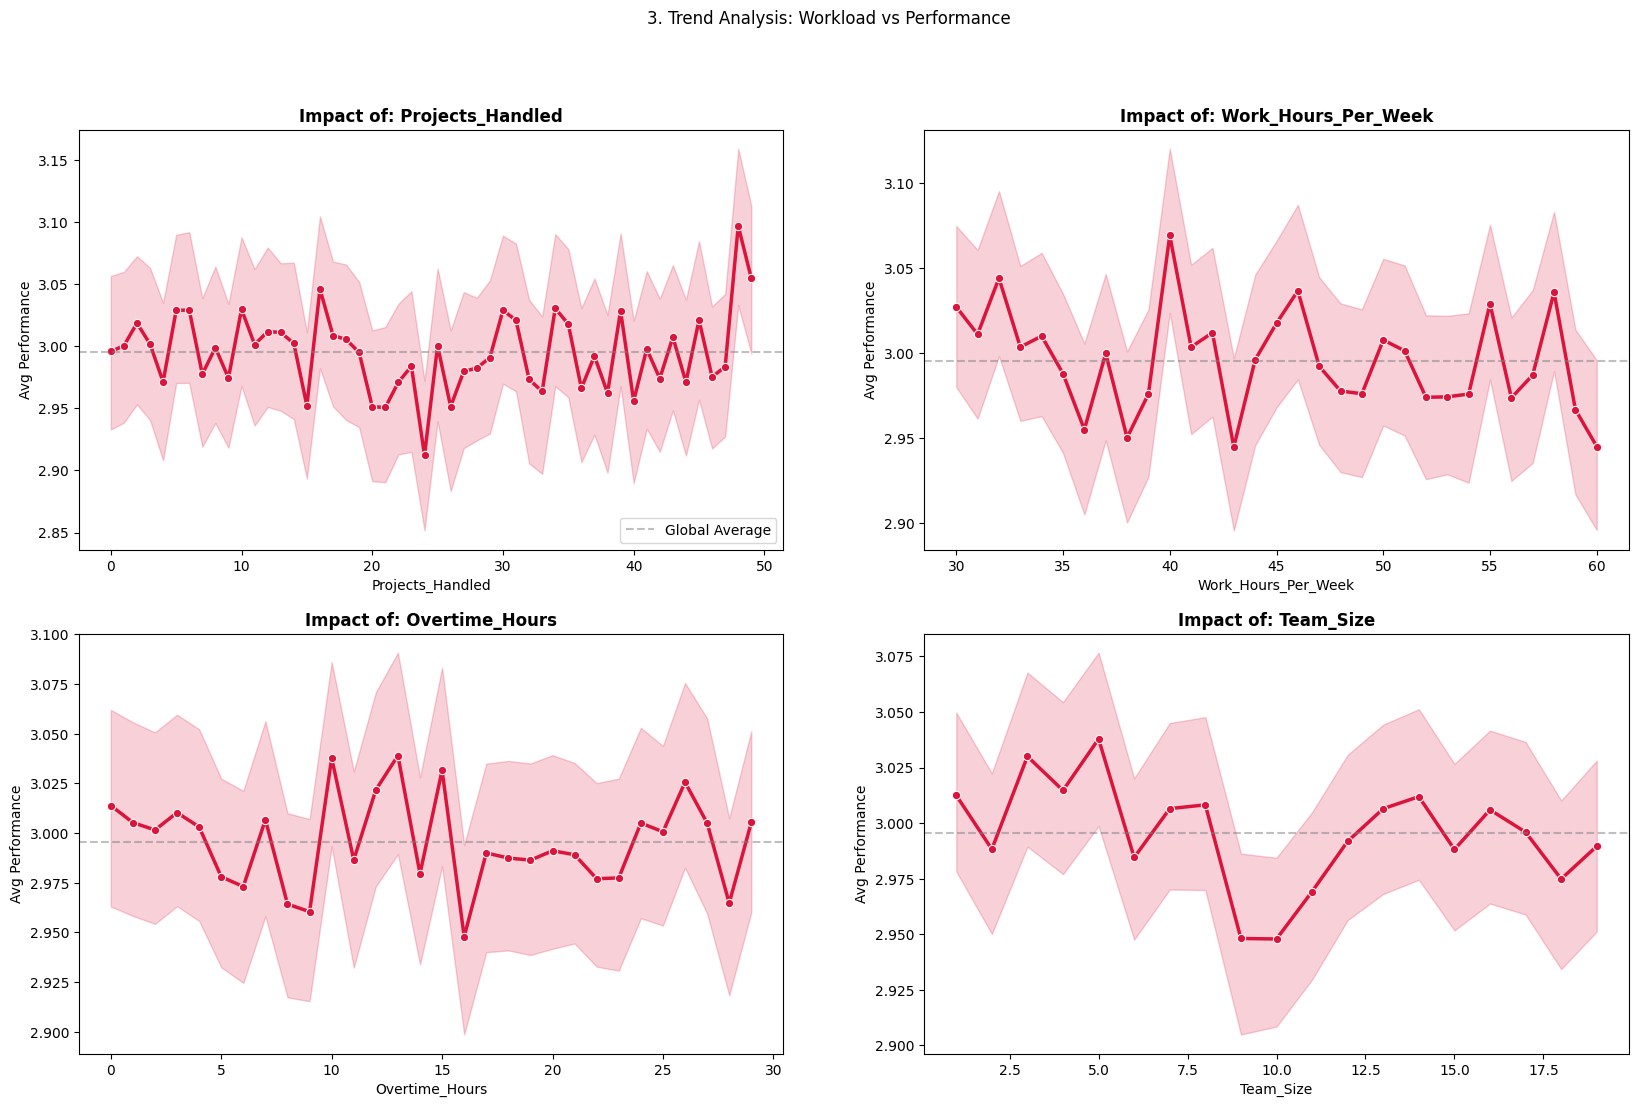

In [11]:
# 3. TRENDS
trend_features = ['Projects_Handled', 'Work_Hours_Per_Week', 'Overtime_Hours', 'Team_Size']

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

global_mean = df['Performance_Score'].mean()

for i, col in enumerate(trend_features):
    ax = axes[i]

    sns.lineplot(data=df, x=col, y='Performance_Score',
                 marker='o', color='crimson', linewidth=2.5, ax=ax)

    ax.axhline(global_mean, color='grey', linestyle='--', alpha=0.5, label='Global Average')

    ax.set_title(f'Impact of: {col}', fontweight='bold')
    ax.set_ylabel('Avg Performance')
    if i == 0:
        ax.legend(loc='lower right')
    else:
        ax.legend().remove()

plt.suptitle("3. Trend Analysis: Workload vs Performance")
plt.show()

 ## Impact of Overtime Hours

- Average performance hovers around the global mean across the entire overtime range, with only small fluctuations, indicating no clear gain from working substantially more overtime.  
- Confidence bands remain wide, so individual performance varies a lot at each overtime level, suggesting that extra hours can reflect both high engagement and overwork.  
- For modeling, Overtime_Hours may capture extreme behavior (very low or very high overtime) but is not a strong linear driver of higher performance scores.  

## Impact of Team Size

- Average performance stays close to the global benchmark across different team sizes, with minor rises and dips but no consistent upward or downward trend.  
- Smaller and larger teams both contain a mix of high and low performers, highlighting that team size alone does not dictate individual performance.  
- Team_Size is likely more useful when combined with role or workload features, helping to identify contexts where coordination complexity may slightly affect performance.  

## Impact of Projects Handled

- As the number of projects increases, average performance shows a mild upward tendency, especially at higher project counts, despite noticeable noise.  
- This pattern suggests that employees trusted with more projects tend, on average, to receive slightly better performance scores, possibly due to experience and demonstrated capability.  
- Projects_Handled can therefore act as a moderately predictive feature, particularly for distinguishing mid‑ to high‑performance classes.  

## Impact of Work Hours Per Week

- Average performance stays near the global mean over the 30–60 hours per week range, with fluctuations but no clear improvement at higher weekly hours.  
- Very long work weeks do not systematically translate into better ratings and may even show small dips, hinting at diminishing returns or burnout effects.  
- Work_Hours_Per_Week adds context about effort level, but like overtime, it should be treated as a non‑linear feature where extremes might matter more than incremental increases.

## **Imbalance Creation**

The initial dataset is almost perfectly balanced. However, this is rarely the case in a real world corporate environment, where the lowest performing employees are typically a small minority. To build a truly useful model, we must simulate this challenge.

In [12]:
def create_intelligent_imbalance(df, target_col='Performance_Score'):
    """
    Create multi-level imbalance scenario:
    - Class 1: Severely underrepresented (1-5% of dataset)
    - Class 2: Moderately underrepresented (~20%)
    - Classes 3, 4, 5: Majority classes (unchanged)
    """
    df_imbalanced = df.copy()

    # Separate by class
    class_1 = df_imbalanced[df_imbalanced[target_col] == 1]
    class_2 = df_imbalanced[df_imbalanced[target_col] == 2]
    class_3 = df_imbalanced[df_imbalanced[target_col] == 3]
    class_4 = df_imbalanced[df_imbalanced[target_col] == 4]
    class_5 = df_imbalanced[df_imbalanced[target_col] == 5]

    # Create severe imbalance for class 1 (keep only 2%)
    n_class_1 = int(len(class_1) * 0.02)
    class_1_sampled = class_1.sample(n=n_class_1, random_state=42)

    # Create moderate imbalance for class 2 (keep 20%)
    n_class_2 = int(len(class_2) * 0.20)
    class_2_sampled = class_2.sample(n=n_class_2, random_state=42)

    # Keep other classes unchanged
    df_imbalanced = pd.concat([class_1_sampled, class_2_sampled,
                               class_3, class_4, class_5], ignore_index=True)

    # Shuffle
    df_imbalanced = df_imbalanced.sample(frac=1, random_state=42).reset_index(drop=True)

    return df_imbalanced


SECTION II: CREATING IMBALANCE

Imbalanced dataset shape: (64271, 20)

Imbalanced class distribution:
Performance_Score
1      402
2     4002
3    19999
4    19940
5    19928
Name: count, dtype: int64

Imbalanced class proportions:
Performance_Score
1    0.006255
2    0.062268
3    0.311167
4    0.310249
5    0.310062
Name: proportion, dtype: float64


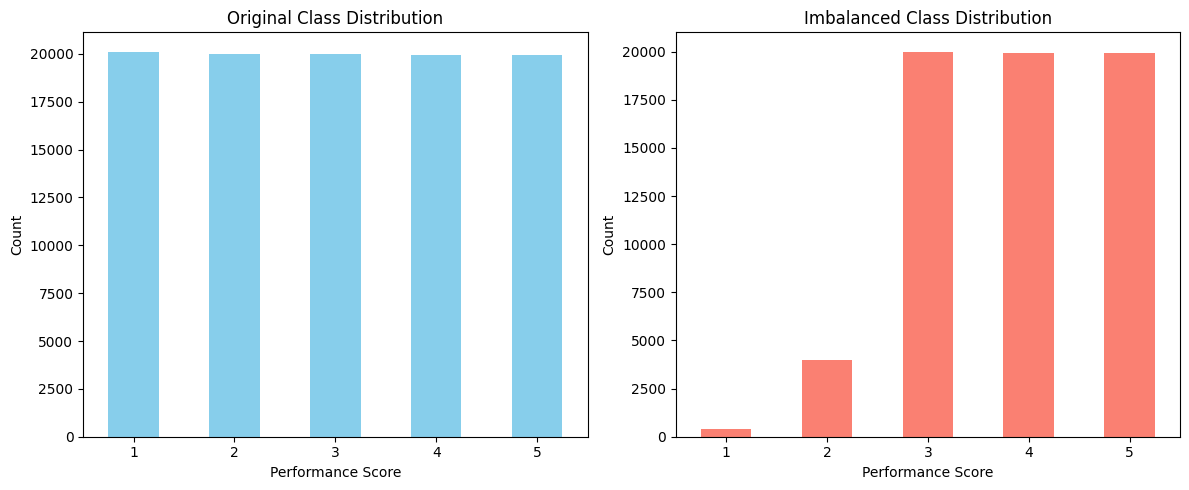

In [13]:
print("\n" + "="*80)
print("SECTION II: CREATING IMBALANCE")
print("="*80)

# Create imbalanced dataset
df_imbalanced = create_intelligent_imbalance(df)

print(f"\nImbalanced dataset shape: {df_imbalanced.shape}")
print(f"\nImbalanced class distribution:")
print(df_imbalanced['Performance_Score'].value_counts().sort_index())
print(f"\nImbalanced class proportions:")
imb_proportions = df_imbalanced['Performance_Score'].value_counts(normalize=True).sort_index()
print(imb_proportions)

# Visualize imbalance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df['Performance_Score'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Original Class Distribution')
plt.xlabel('Performance Score')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df_imbalanced['Performance_Score'].value_counts().sort_index().plot(kind='bar', color='salmon')
plt.title('Imbalanced Class Distribution')
plt.xlabel('Performance Score')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
# plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')

We can now see that two classes are now imbalanced namely class 1 and class 2. Now the next task would be to handle this imbalance by using several techniques.

## **Feature Engineering and Preprocessing**

In [14]:
print("\n" + "="*80)
print("SECTION III: FEATURE ENGINEERING & PREPROCESSING")
print("="*80)

# Separate features and target
X = df_imbalanced.drop('Performance_Score', axis=1)
y = df_imbalanced['Performance_Score']

# Encode categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns
print(f"\nCategorical columns: {list(categorical_cols)}")

le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    le_dict[col] = le

# Check correlation with target
numeric_data = X.copy()
numeric_data['Performance_Score'] = y
correlation_matrix = numeric_data.corr()

print(f"\nCorrelation with Performance Score:")
target_corr = correlation_matrix['Performance_Score'].sort_values(ascending=False)
print(target_corr)

# Check multicollinearity
print(f"\nTop correlated feature pairs (potential multicollinearity):")
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            corr_pairs.append((correlation_matrix.columns[i],
                              correlation_matrix.columns[j],
                              correlation_matrix.iloc[i, j]))

if corr_pairs:
    for pair in corr_pairs[:5]:  # Show top 5
        print(f"{pair[0]} <-> {pair[1]}: {pair[2]:.3f}")
else:
    print("No high multicollinearity detected (threshold: 0.7)")





SECTION III: FEATURE ENGINEERING & PREPROCESSING

Categorical columns: ['Department', 'Gender', 'Job_Title', 'Hire_Date', 'Education_Level']

Correlation with Performance Score:
Performance_Score              1.000000
Monthly_Salary                 0.351984
Gender                         0.006583
Remote_Work_Frequency          0.005715
Education_Level                0.005264
Years_At_Company               0.001207
Employee_Satisfaction_Score    0.000302
Training_Hours                 0.000284
Age                            0.000269
Job_Title                     -0.000418
Hire_Date                     -0.000851
Resigned                      -0.001059
Overtime_Hours                -0.001467
Projects_Handled              -0.002643
Team_Size                     -0.005957
Promotions                    -0.006248
Department                    -0.006689
Employee_ID                   -0.007146
Sick_Days                     -0.007542
Work_Hours_Per_Week           -0.010370
Name: Performance_Sco

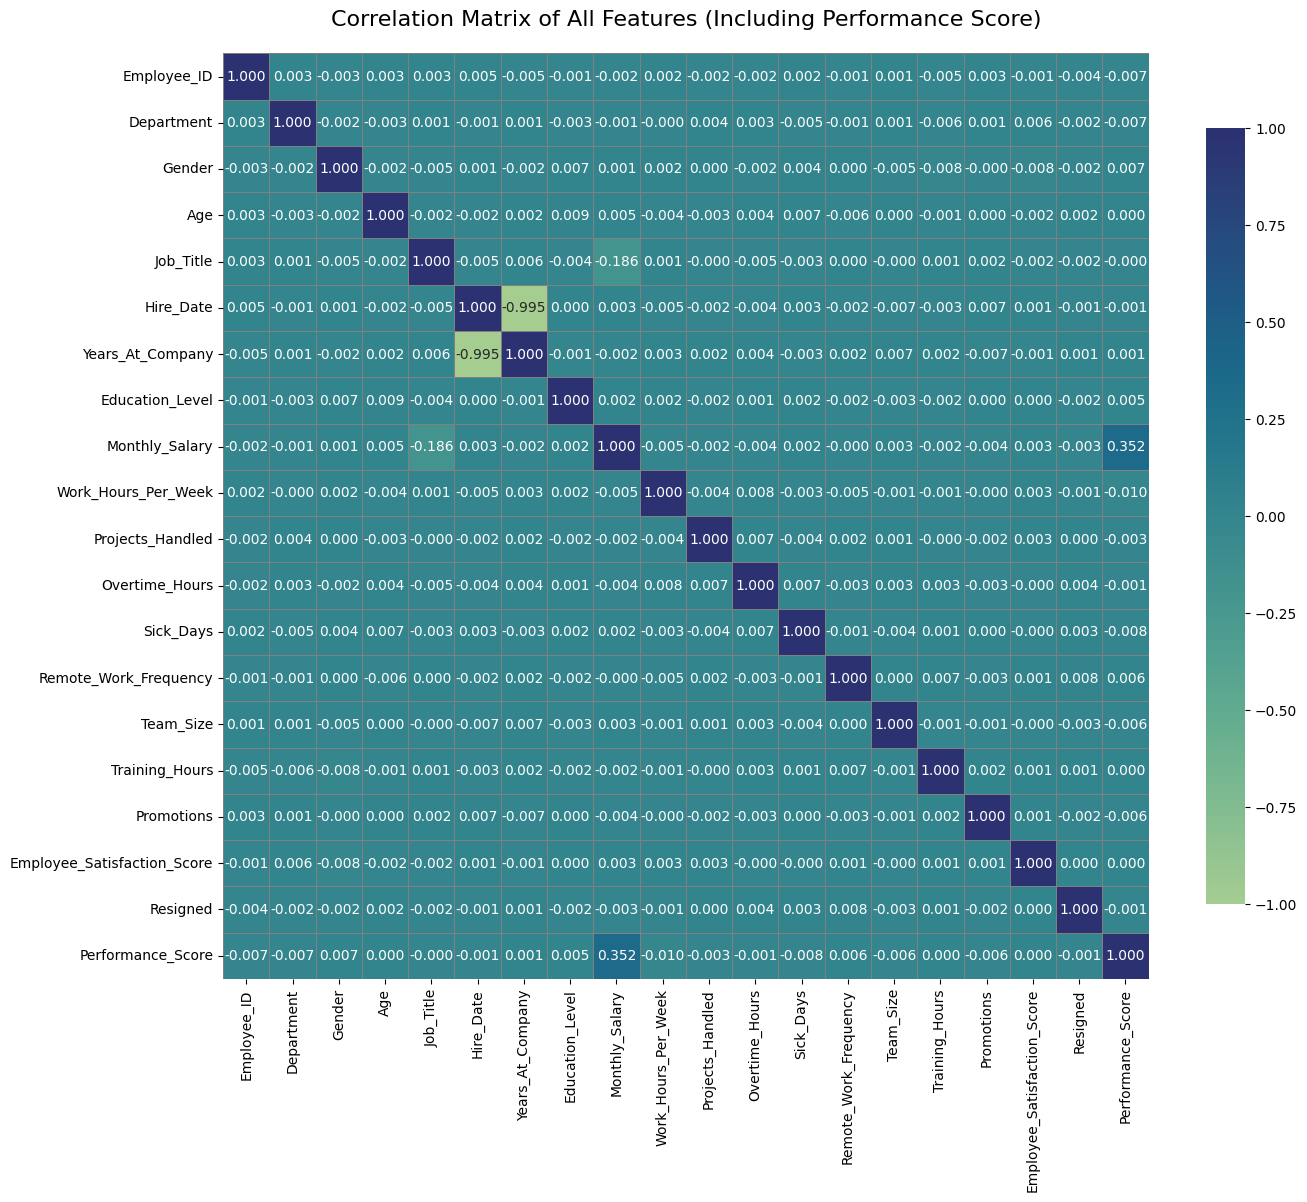

In [15]:

# SEABORN CORRELATION MATRIX

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(14, 12))
mask_upper_triangle = False

if mask_upper_triangle:
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
else:
    mask = None

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".3f",
    cmap="crest",
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar_kws={"shrink": 0.8},
    mask=mask
)

plt.title(
    "Correlation Matrix of All Features (Including Performance Score)",
    fontsize=16,
    pad=20
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


We can see that most of the columns have nearly no correlation with the target Performance score except Monthly Salary. So we drop some of them whose absolute correlation is less than a threshold. Moreover, we also drop some other redundant features.

In [16]:

# DROP IRRELEVANT FEATURES BASED ON LOW TARGET CORRELATION

corr_with_target = correlation_matrix['Performance_Score'].abs()

# Threshold for relevance
relevance_threshold = 0.001  # adjust as needed

irrelevant_features = corr_with_target[np.abs(corr_with_target) < relevance_threshold].index.tolist()

print("Irrelevant features (correlation < threshold):")
print(irrelevant_features)

# Drop from dataset
X_reduced = X.drop(columns=irrelevant_features)


Irrelevant features (correlation < threshold):
['Age', 'Job_Title', 'Hire_Date', 'Training_Hours', 'Employee_Satisfaction_Score']


In [17]:

# DROP REDUNDANT FEATURES BASED ON HIGH INTER-FEATURE CORRELATION

corr_matrix = correlation_matrix.drop("Performance_Score", axis=1).drop("Performance_Score", axis=0)

redundant_features = set()
multicollinearity_threshold = 0.80  # adjust as needed

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > multicollinearity_threshold:
            # Add one of the two features to the remove list
            redundant_features.add(corr_matrix.columns[j])

print("\nRedundant (highly correlated) features:")
print(list(redundant_features))

# Drop redundant columns
X_reduced = X_reduced.drop(columns=list(redundant_features), errors='ignore')
X_reduced_sal = X_reduced.drop(columns = ['Employee_ID'])
X_reduced = X_reduced.drop(columns = ['Employee_ID','Monthly_Salary'])


Redundant (highly correlated) features:
['Years_At_Company']


## **Train-Test Split**

We try to train models with the monthly salary and without it since intuitively performance score should not be predicted using the salary but it should be the other way around. However, since the only strongly correlated feature to the target in our dataset is Monthly Salary, we see a huge drop in the preformance of the models below when we drop the same.

### Without Monthly Salary

In [18]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTrain set class distribution:")
print(y_train.value_counts().sort_index())

# Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


Train set size: (51416, 11)
Test set size: (12855, 11)

Train set class distribution:
Performance_Score
1      322
2     3201
3    15999
4    15952
5    15942
Name: count, dtype: int64


### With Monthly Salary

In [19]:
# Split data
X_train_sal, X_test_sal, y_train_sal, y_test_sal = train_test_split(
    X_reduced_sal, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set size: {X_train_sal.shape}")
print(f"Test set size: {X_test_sal.shape}")
print(f"\nTrain set class distribution:")
print(y_train_sal.value_counts().sort_index())

# Standardize numeric features
scaler = StandardScaler()
X_train_scaled_sal = scaler.fit_transform(X_train_sal)
X_test_scaled_sal = scaler.transform(X_test_sal)

# Convert back to DataFrame for easier handling
X_train_scaled_sal = pd.DataFrame(X_train_scaled_sal, columns=X_train_sal.columns)
X_test_scaled_sal = pd.DataFrame(X_test_scaled_sal, columns=X_test_sal.columns)


Train set size: (51416, 12)
Test set size: (12855, 12)

Train set class distribution:
Performance_Score
1      322
2     3201
3    15999
4    15952
5    15942
Name: count, dtype: int64


# Training and Evaluation

The training–evaluation pipeline is the same for all models: after simulating class imbalance, categorical features are label‑encoded, low‑correlation and redundant columns are dropped, then the data is split into 80% train and 20% test with stratification, and numeric features are standardized; two parallel pipelines are run, one excluding Monthly_Salary and one including it. Baseline models are multinomial logistic regression (sklearn and a custom softmax implementation) trained on the scaled features with up to 2000 iterations, evaluated on the fixed test set using scikit‑learn’s classification_report plus macro F1 and per‑class recall; confusion matrices are also inspected to understand where errors concentrate.

To handle the engineered imbalance, the notebook applies RandomUnderSampler, SMOTE oversampling, and class‑weighted logistic regression, always fitting on resampled or reweighted training data and evaluating on the original untouched test set so the metrics remain comparable. Tree‑based models are then trained with explicit class weighting: BalancedRandomForestClassifier balances bootstrap samples per tree, a class‑weighted RandomForestClassifier adjusts split criteria via class_weight='balanced', and XGBoost uses class‑dependent sample weights; each of these is again evaluated on the same test split using macro F1 and per‑class recall, and their scores are summarized in comparison tables and a heatmap. Finally, because the untuned XGBoost with salary clearly dominates, a 5‑fold GridSearchCV over depth, learning rate, estimators, and sampling parameters is run (scoring on macro F1), the best estimator is refit on the full training set with class weights, and its test performance (≈98.7% accuracy and ≈0.92 macro F1) is reported as the final model.

## **Baseline Model**

For all the following cells, we execute a series of models first without salary and second with salary. We choose the baseline model as  Logistic Regression and then try to improve the preformace using a series of other models. For understanding purposes we also make a Logistic regression model from scratch.

In [20]:
print("\n" + "="*80)
print("SECTION IV: BASELINE MODEL (No Imbalance Handling)")
print("="*80)

# Train baseline logistic regression
baseline_lr = LogisticRegression(max_iter=2000, random_state=42, multi_class='multinomial')
baseline_lr.fit(X_train_scaled, y_train)
y_pred_baseline = baseline_lr.predict(X_test_scaled)

print("\nBaseline Logistic Regression Results:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, digits=3))

print("\nConfusion Matrix:")
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print(cm_baseline)

# Per-class metrics
print("\nPer-Class Metrics:")
for class_label in sorted(y_test.unique()):
    class_mask = y_test == class_label
    class_pred = y_pred_baseline[class_mask]
    class_recall = recall_score(y_test[class_mask], class_pred, average='micro')
    print(f"Class {class_label} Recall: {class_recall:.3f}")

baseline_macro_f1 = f1_score(y_test, y_pred_baseline, average='macro')
print(f"\nBaseline Macro F1-Score: {baseline_macro_f1:.3f}")


SECTION IV: BASELINE MODEL (No Imbalance Handling)

Baseline Logistic Regression Results:

Classification Report:
              precision    recall  f1-score   support

           1      0.000     0.000     0.000        80
           2      0.000     0.000     0.000       801
           3      0.317     0.438     0.368      4000
           4      0.312     0.277     0.293      3988
           5      0.311     0.296     0.303      3986

    accuracy                          0.314     12855
   macro avg      0.188     0.202     0.193     12855
weighted avg      0.292     0.314     0.300     12855


Confusion Matrix:
[[   0    0   34   24   22]
 [   0    0  355  228  218]
 [   0    0 1750 1069 1181]
 [   0    0 1684 1105 1199]
 [   0    0 1690 1116 1180]]

Per-Class Metrics:
Class 1 Recall: 0.000
Class 2 Recall: 0.000
Class 3 Recall: 0.438
Class 4 Recall: 0.277
Class 5 Recall: 0.296

Baseline Macro F1-Score: 0.193


In [21]:
print("\n" + "="*80)
print("SECTION IV: BASELINE MODEL (No Imbalance Handling)")
print("="*80)

# Train baseline logistic regression
baseline_lr_sal = LogisticRegression(max_iter=2000, random_state=42, multi_class='multinomial')
baseline_lr_sal.fit(X_train_scaled_sal, y_train_sal)
y_pred_baseline_sal = baseline_lr_sal.predict(X_test_scaled_sal)

print("\nBaseline Logistic Regression Results:")
print("\nClassification Report:")
print(classification_report(y_test_sal, y_pred_baseline_sal, digits=3))

print("\nConfusion Matrix:")
cm_baseline_sal = confusion_matrix(y_test_sal, y_pred_baseline_sal)
print(cm_baseline_sal)

# Per-class metrics
print("\nPer-Class Metrics:")
for class_label_sal in sorted(y_test_sal.unique()):
    class_mask_sal = y_test_sal == class_label_sal
    class_pred_sal = y_pred_baseline[class_mask_sal]
    class_recall_sal = recall_score(y_test_sal[class_mask_sal], class_pred_sal, average='micro')
    print(f"Class {class_label_sal} Recall: {class_recall_sal:.3f}")

baseline_macro_f1_sal = f1_score(y_test_sal, y_pred_baseline_sal, average='macro')
print(f"\nBaseline Macro F1-Score: {baseline_macro_f1_sal:.3f}")


SECTION IV: BASELINE MODEL (No Imbalance Handling)

Baseline Logistic Regression Results:

Classification Report:
              precision    recall  f1-score   support

           1      0.000     0.000     0.000        80
           2      0.000     0.000     0.000       801
           3      0.371     0.540     0.440      4000
           4      0.371     0.131     0.194      3988
           5      0.402     0.568     0.471      3986

    accuracy                          0.385     12855
   macro avg      0.229     0.248     0.221     12855
weighted avg      0.355     0.385     0.343     12855


Confusion Matrix:
[[   0    0   68   12    0]
 [   0    0  530  105  166]
 [   0    0 2159  379 1462]
 [   0    0 1725  523 1740]
 [   0    0 1332  389 2265]]

Per-Class Metrics:
Class 1 Recall: 0.000
Class 2 Recall: 0.000
Class 3 Recall: 0.438
Class 4 Recall: 0.277
Class 5 Recall: 0.296

Baseline Macro F1-Score: 0.221


## **Handling Imbalance Using Existing Approaches**

We try to handle the imbalance in the dataset using standard approaches. First we try, Random Oversampling (for minority class) method followed by random undersampling (for majority class). Then we try SMOTE which is one of the most common approaches for handling class imbalance. We couldn't try ADASYN due to time contraints. However, out of all these approaches we found out that the implicit class imbalance handling of Random Forest exceeds in performance to these standard methods.

**NOTE:**

 _We have performed the resampling and training using multiple approaches. For each approach, we first try resampling **without** the Employee Salary column, which was highly correlated with the target column, and then we try the same resampling approach **including** the Employee Salary column. The same method goes for all the trained models as well._

In [22]:
print("\n" + "="*80)
print("SECTION V: IMBALANCE HANDLING METHODS")
print("="*80)

results = {'Method': [], 'Macro_F1': [], 'Per_Class_Recall': []}


SECTION V: IMBALANCE HANDLING METHODS


In [23]:
print("\n" + "="*80)
print("SECTION V: IMBALANCE HANDLING METHODS")
print("="*80)

results_sal = {'Method': [], 'Macro_F1': [], 'Per_Class_Recall': []}


SECTION V: IMBALANCE HANDLING METHODS


In [24]:
# Method 1: Random Undersampling
print("\n" + "-"*80)
print("Method 1: Random Undersampling")
print("-"*80)

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)

print(f"After undersampling: {Counter(y_train_rus)}")

lr_rus = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = lr_rus.predict(X_test_scaled)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rus, digits=3))

macro_f1_rus = f1_score(y_test, y_pred_rus, average='macro')
per_class_recall_rus = recall_score(y_test, y_pred_rus, average=None)

results['Method'].append('Random Undersampling')
results['Macro_F1'].append(macro_f1_rus)
results['Per_Class_Recall'].append(per_class_recall_rus)


--------------------------------------------------------------------------------
Method 1: Random Undersampling
--------------------------------------------------------------------------------
After undersampling: Counter({1: 322, 2: 322, 3: 322, 4: 322, 5: 322})

Classification Report:
              precision    recall  f1-score   support

           1      0.007     0.263     0.013        80
           2      0.066     0.210     0.100       801
           3      0.313     0.202     0.245      4000
           4      0.328     0.209     0.255      3988
           5      0.318     0.161     0.214      3986

    accuracy                          0.192     12855
   macro avg      0.206     0.209     0.165     12855
weighted avg      0.302     0.192     0.228     12855



In [25]:
# Method 1: Random Undersampling
print("\n" + "-"*80)
print("Method 1: Random Undersampling")
print("-"*80)

rus_sal = RandomUnderSampler(random_state=42)
X_train_rus_sal, y_train_rus_sal = rus_sal.fit_resample(X_train_scaled_sal, y_train_sal)

print(f"After undersampling: {Counter(y_train_rus_sal)}")

lr_rus_sal = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr_rus_sal.fit(X_train_rus_sal, y_train_rus_sal)
y_pred_rus_sal = lr_rus_sal.predict(X_test_scaled_sal)

print("\nClassification Report:")
print(classification_report(y_test_sal, y_pred_rus_sal, digits=3))

macro_f1_rus_sal = f1_score(y_test_sal, y_pred_rus_sal, average='macro')
per_class_recall_rus_sal = recall_score(y_test_sal, y_pred_rus_sal, average=None)

results_sal['Method'].append('Random Undersampling')
results_sal['Macro_F1'].append(macro_f1_rus_sal)
results_sal['Per_Class_Recall'].append(per_class_recall_rus_sal)


--------------------------------------------------------------------------------
Method 1: Random Undersampling
--------------------------------------------------------------------------------
After undersampling: Counter({1: 322, 2: 322, 3: 322, 4: 322, 5: 322})

Classification Report:
              precision    recall  f1-score   support

           1      0.015     0.487     0.029        80
           2      0.073     0.149     0.098       801
           3      0.308     0.124     0.177      4000
           4      0.287     0.120     0.170      3988
           5      0.407     0.543     0.465      3986

    accuracy                          0.256     12855
   macro avg      0.218     0.285     0.188     12855
weighted avg      0.316     0.256     0.258     12855



In [26]:
# Method 2: SMOTE
print("\n" + "-"*80)
print("Method 2: SMOTE (Synthetic Minority Over-sampling)")
print("-"*80)

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE: {Counter(y_train_smote)}")

lr_smote = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = lr_smote.predict(X_test_scaled)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote, digits=3))

macro_f1_smote = f1_score(y_test, y_pred_smote, average='macro')
per_class_recall_smote = recall_score(y_test, y_pred_smote, average=None)

results['Method'].append('SMOTE')
results['Macro_F1'].append(macro_f1_smote)
results['Per_Class_Recall'].append(per_class_recall_smote)


--------------------------------------------------------------------------------
Method 2: SMOTE (Synthetic Minority Over-sampling)
--------------------------------------------------------------------------------
After SMOTE: Counter({5: 15999, 4: 15999, 3: 15999, 2: 15999, 1: 15999})

Classification Report:
              precision    recall  f1-score   support

           1      0.007     0.438     0.014        80
           2      0.058     0.210     0.091       801
           3      0.314     0.138     0.191      4000
           4      0.316     0.093     0.143      3988
           5      0.298     0.168     0.215      3986

    accuracy                          0.139     12855
   macro avg      0.199     0.209     0.131     12855
weighted avg      0.292     0.139     0.176     12855



In [27]:
# Method 2: SMOTE
print("\n" + "-"*80)
print("Method 2: SMOTE (Synthetic Minority Over-sampling)")
print("-"*80)

smote_sal = SMOTE(random_state=42, k_neighbors=5)
X_train_smote_sal, y_train_smote_sal = smote_sal.fit_resample(X_train_scaled_sal, y_train_sal)

print(f"After SMOTE: {Counter(y_train_smote_sal)}")

lr_smote_sal = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr_smote_sal.fit(X_train_smote_sal, y_train_smote_sal)
y_pred_smote_sal = lr_smote_sal.predict(X_test_scaled_sal)

print("\nClassification Report:")
print(classification_report(y_test_sal, y_pred_smote_sal, digits=3))

macro_f1_smote_sal = f1_score(y_test_sal, y_pred_smote_sal, average='macro')
per_class_recall_smote_sal = recall_score(y_test_sal, y_pred_smote_sal, average=None)

results_sal['Method'].append('SMOTE')
results_sal['Macro_F1'].append(macro_f1_smote_sal)
results_sal['Per_Class_Recall'].append(per_class_recall_smote_sal)


--------------------------------------------------------------------------------
Method 2: SMOTE (Synthetic Minority Over-sampling)
--------------------------------------------------------------------------------
After SMOTE: Counter({5: 15999, 4: 15999, 3: 15999, 2: 15999, 1: 15999})

Classification Report:
              precision    recall  f1-score   support

           1      0.015     0.537     0.029        80
           2      0.074     0.149     0.098       801
           3      0.350     0.114     0.172      4000
           4      0.382     0.132     0.196      3988
           5      0.401     0.568     0.470      3986

    accuracy                          0.265     12855
   macro avg      0.244     0.300     0.193     12855
weighted avg      0.356     0.265     0.266     12855



In [28]:
# Method 3: Class-Weighted Logistic Regression
print("\n" + "-"*80)
print("Method 3: Class-Weighted Logistic Regression")
print("-"*80)

lr_weighted = LogisticRegression(max_iter=1000, random_state=42,
                                 multi_class='multinomial', class_weight='balanced')
lr_weighted.fit(X_train_scaled, y_train)
y_pred_weighted = lr_weighted.predict(X_test_scaled)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_weighted, digits=3))

macro_f1_weighted = f1_score(y_test, y_pred_weighted, average='macro')
per_class_recall_weighted = recall_score(y_test, y_pred_weighted, average=None)

results['Method'].append('Class-Weighted LR')
results['Macro_F1'].append(macro_f1_weighted)
results['Per_Class_Recall'].append(per_class_recall_weighted)


--------------------------------------------------------------------------------
Method 3: Class-Weighted Logistic Regression
--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           1      0.007     0.425     0.014        80
           2      0.064     0.192     0.096       801
           3      0.310     0.181     0.228      4000
           4      0.347     0.091     0.144      3988
           5      0.302     0.166     0.214      3986

    accuracy                          0.151     12855
   macro avg      0.206     0.211     0.139     12855
weighted avg      0.302     0.151     0.188     12855



In [29]:
# Method 3: Class-Weighted Logistic Regression
print("\n" + "-"*80)
print("Method 3: Class-Weighted Logistic Regression")
print("-"*80)

lr_weighted_sal = LogisticRegression(max_iter=1000, random_state=42,
                                 multi_class='multinomial', class_weight='balanced')
lr_weighted_sal.fit(X_train_scaled_sal, y_train_sal)
y_pred_weighted_sal = lr_weighted_sal.predict(X_test_scaled_sal)

print("\nClassification Report:")
print(classification_report(y_test_sal, y_pred_weighted_sal, digits=3))

macro_f1_weighted_sal = f1_score(y_test_sal, y_pred_weighted_sal, average='macro')
per_class_recall_weighted_sal = recall_score(y_test_sal, y_pred_weighted_sal, average=None)

results_sal['Method'].append('Class-Weighted LR')
results_sal['Macro_F1'].append(macro_f1_weighted_sal)
results_sal['Per_Class_Recall'].append(per_class_recall_weighted_sal)


--------------------------------------------------------------------------------
Method 3: Class-Weighted Logistic Regression
--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           1      0.015     0.537     0.029        80
           2      0.071     0.142     0.094       801
           3      0.359     0.119     0.179      4000
           4      0.382     0.132     0.196      3988
           5      0.402     0.568     0.471      3986

    accuracy                          0.266     12855
   macro avg      0.246     0.300     0.194     12855
weighted avg      0.359     0.266     0.269     12855



In [30]:
# Method 4: Balanced Random Forest
print("\n" + "-"*80)
print("Method 4: Balanced Random Forest")
print("-"*80)

brf = BalancedRandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
brf.fit(X_train_scaled, y_train)
y_pred_brf = brf.predict(X_test_scaled)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_brf, digits=3))

macro_f1_brf = f1_score(y_test, y_pred_brf, average='macro')
per_class_recall_brf = recall_score(y_test, y_pred_brf, average=None)

results['Method'].append('Balanced Random Forest')
results['Macro_F1'].append(macro_f1_brf)
results['Per_Class_Recall'].append(per_class_recall_brf)


--------------------------------------------------------------------------------
Method 4: Balanced Random Forest
--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           1      0.008     0.100     0.015        80
           2      0.063     0.226     0.098       801
           3      0.304     0.253     0.276      4000
           4      0.301     0.212     0.249      3988
           5      0.313     0.224     0.261      3986

    accuracy                          0.229     12855
   macro avg      0.198     0.203     0.180     12855
weighted avg      0.289     0.229     0.250     12855



In [31]:
# Method 4: Balanced Random Forest
print("\n" + "-"*80)
print("Method 4: Balanced Random Forest")
print("-"*80)

brf_sal = BalancedRandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
brf_sal.fit(X_train_scaled_sal, y_train_sal)
y_pred_brf_sal = brf_sal.predict(X_test_scaled_sal)

print("\nClassification Report:")
print(classification_report(y_test_sal, y_pred_brf_sal, digits=3))

macro_f1_brf_sal = f1_score(y_test_sal, y_pred_brf_sal, average='macro')
per_class_recall_brf_sal = recall_score(y_test_sal, y_pred_brf_sal, average=None)

results_sal['Method'].append('Balanced Random Forest')
results_sal['Macro_F1'].append(macro_f1_brf_sal)
results_sal['Per_Class_Recall'].append(per_class_recall_brf_sal)


--------------------------------------------------------------------------------
Method 4: Balanced Random Forest
--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           1      0.045     0.512     0.083        80
           2      0.287     0.816     0.425       801
           3      0.790     0.777     0.784      4000
           4      0.963     0.692     0.805      3988
           5      0.998     0.719     0.835      3986

    accuracy                          0.733     12855
   macro avg      0.617     0.703     0.586     12855
weighted avg      0.872     0.733     0.780     12855



## **Logistic Regression From Scratch**


SECTION VI: FROM-SCRATCH MULTICLASS LOGISTIC REGRESSION

Training from-scratch Logistic Regression...

Computed class weights: {5: 0.645038263705934, 4: 0.6446339017051154, 3: 0.6427401712607038, 2: 3.2124960949703216, 1: 31.935403726708074}
Iteration 100/500, Loss: 1.6060
Iteration 200/500, Loss: 1.6059
Iteration 300/500, Loss: 1.6059
Iteration 400/500, Loss: 1.6059
Iteration 500/500, Loss: 1.6059

Performing gradient check...
Gradient check relative error: 3.45e-03
Gradient check failed. Check implementation.

From-Scratch Logistic Regression Results:

Classification Report:
              precision    recall  f1-score   support

           1      0.007     0.425     0.014        80
           2      0.064     0.192     0.096       801
           3      0.309     0.180     0.228      4000
           4      0.348     0.090     0.143      3988
           5      0.303     0.167     0.215      3986

    accuracy                          0.151     12855
   macro avg      0.206     0.211  

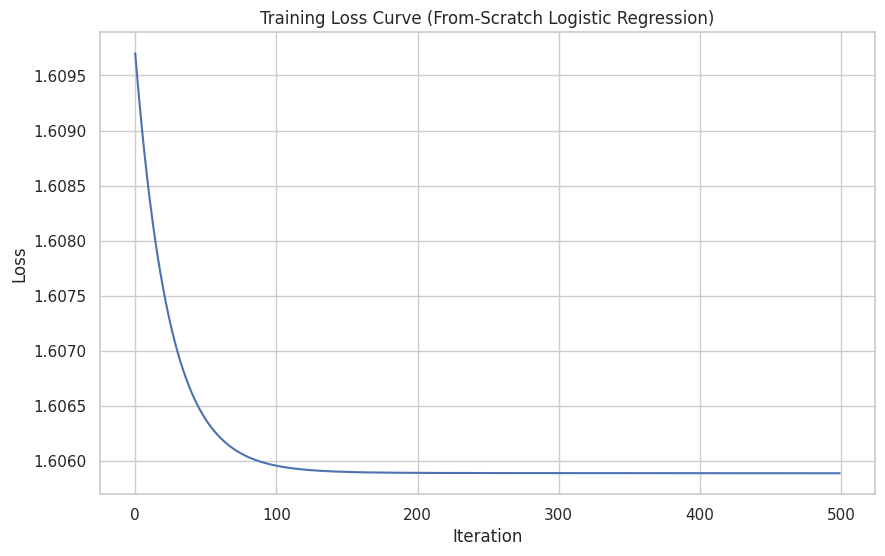

In [ ]:
print("\n" + "="*80)
print("SECTION VI: FROM-SCRATCH MULTICLASS LOGISTIC REGRESSION")
print("="*80)

class MulticlassLogisticRegression:
    """
    Multiclass Logistic Regression with Softmax from scratch
    Supports L2 regularization and class weighting
    """

    def __init__(self, learning_rate=0.01, n_iterations=1000,
                 lambda_reg=0.01, class_weights=None):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.lambda_reg = lambda_reg
        self.class_weights = class_weights
        self.weights = None
        self.bias = None
        self.loss_history = []

    def softmax(self, z):
        """Compute softmax activation"""
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def compute_loss(self, y_true_one_hot, y_pred, sample_weights):
        """Compute cross-entropy loss with L2 regularization"""
        n_samples = y_true_one_hot.shape[0]

        # Cross-entropy loss with sample weights
        ce_loss = -np.sum(sample_weights[:, np.newaxis] * y_true_one_hot * np.log(y_pred + 1e-15)) / n_samples

        # L2 regularization
        l2_loss = (self.lambda_reg / 2) * np.sum(self.weights ** 2)

        return ce_loss + l2_loss

    def fit(self, X, y):
        """Train the model using gradient descent"""
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        # Initialize weights and bias
        self.weights = np.random.randn(n_features, n_classes) * 0.01
        self.bias = np.zeros((1, n_classes))

        # Convert y to one-hot encoding
        y_one_hot = np.zeros((n_samples, n_classes))
        y_one_hot[np.arange(n_samples), y - 1] = 1  # Assuming classes are 1-5

        # Compute sample weights based on class weights
        if self.class_weights is not None:
            sample_weights = np.array([self.class_weights.get(label, 1.0) for label in y])
        else:
            sample_weights = np.ones(n_samples)

        # Gradient descent
        for iteration in range(self.n_iterations):
            # Forward pass
            z = np.dot(X, self.weights) + self.bias
            y_pred = self.softmax(z)

            # Compute loss
            loss = self.compute_loss(y_one_hot, y_pred, sample_weights)
            self.loss_history.append(loss)

            # Backward pass
            error = y_pred - y_one_hot
            error = error * sample_weights[:, np.newaxis]  # Apply sample weights

            dw = np.dot(X.T, error) / n_samples + self.lambda_reg * self.weights
            db = np.sum(error, axis=0, keepdims=True) / n_samples

            # Update weights
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Print progress
            if (iteration + 1) % 100 == 0:
                print(f"Iteration {iteration + 1}/{self.n_iterations}, Loss: {loss:.4f}")

        return self

    def predict_proba(self, X):
        """Predict class probabilities"""
        z = np.dot(X, self.weights) + self.bias
        return self.softmax(z)

    def predict(self, X):
        """Predict class labels"""
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1) + 1  # Add 1 to get classes 1-5

    def gradient_check(self, X, y, epsilon=1e-7):
        """Perform gradient checking"""
        n_samples = X.shape[0]
        y_one_hot = np.zeros((n_samples, self.weights.shape[1]))
        y_one_hot[np.arange(n_samples), y - 1] = 1
        sample_weights = np.ones(n_samples)

        # Compute analytical gradients
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(z)
        error = y_pred - y_one_hot
        dw_analytical = np.dot(X.T, error) / n_samples + self.lambda_reg * self.weights

        # Compute numerical gradients
        dw_numerical = np.zeros_like(self.weights)
        for i in range(self.weights.shape[0]):
            for j in range(self.weights.shape[1]):
                weights_plus = self.weights.copy()
                weights_plus[i, j] += epsilon
                z_plus = np.dot(X, weights_plus) + self.bias
                y_pred_plus = self.softmax(z_plus)
                loss_plus = self.compute_loss(y_one_hot, y_pred_plus, sample_weights)

                weights_minus = self.weights.copy()
                weights_minus[i, j] -= epsilon
                z_minus = np.dot(X, weights_minus) + self.bias
                y_pred_minus = self.softmax(z_minus)
                loss_minus = self.compute_loss(y_one_hot, y_pred_minus, sample_weights)

                dw_numerical[i, j] = (loss_plus - loss_minus) / (2 * epsilon)

        # Compute relative error
        relative_error = np.linalg.norm(dw_analytical - dw_numerical) / (
            np.linalg.norm(dw_analytical) + np.linalg.norm(dw_numerical) + 1e-8
        )

        print(f"Gradient check relative error: {relative_error:.2e}")
        if relative_error < 1e-5:
            print("Gradient check passed!")
        else:
            print("Gradient check failed. Check implementation.")

        return relative_error

# Train from-scratch model
print("\nTraining from-scratch Logistic Regression...")

# Compute class weights
class_counts = Counter(y_train)
total_samples = len(y_train)
class_weights_dict = {cls: total_samples / (len(class_counts) * count)
                      for cls, count in class_counts.items()}

print(f"\nComputed class weights: {class_weights_dict}")

# Initialize and train
scratch_lr = MulticlassLogisticRegression(
    learning_rate=0.1,
    n_iterations=500,
    lambda_reg=0.01,
    class_weights=class_weights_dict
)

scratch_lr.fit(X_train_scaled.values, y_train.values)

# Gradient check on small subset
print("\nPerforming gradient check...")
X_check = X_train_scaled.values[:100]
y_check = y_train.values[:100]
scratch_lr.gradient_check(X_check, y_check)

# Predictions
y_pred_scratch = scratch_lr.predict(X_test_scaled.values)

print("\nFrom-Scratch Logistic Regression Results:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_scratch, digits=3))

macro_f1_scratch = f1_score(y_test, y_pred_scratch, average='macro')
per_class_recall_scratch = recall_score(y_test, y_pred_scratch, average=None)

results['Method'].append('From-Scratch LR (Weighted)')
results['Macro_F1'].append(macro_f1_scratch)
results['Per_Class_Recall'].append(per_class_recall_scratch)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(scratch_lr.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve (From-Scratch Logistic Regression)')
plt.grid(True)



SECTION VI: FROM-SCRATCH MULTICLASS LOGISTIC REGRESSION

Training from-scratch Logistic Regression...

Computed class weights: {5: 0.645038263705934, 4: 0.6446339017051154, 3: 0.6427401712607038, 2: 3.2124960949703216, 1: 31.935403726708074}
Iteration 100/500, Loss: 1.4758
Iteration 200/500, Loss: 1.4678
Iteration 300/500, Loss: 1.4665
Iteration 400/500, Loss: 1.4662
Iteration 500/500, Loss: 1.4661

Performing gradient check...
Gradient check relative error: 2.10e-02
Gradient check failed. Check implementation.

From-Scratch Logistic Regression Results:

Classification Report:
              precision    recall  f1-score   support

           1      0.014     0.537     0.027        80
           2      0.066     0.125     0.086       801
           3      0.362     0.113     0.172      4000
           4      0.392     0.121     0.185      3988
           5      0.391     0.568     0.463      3986

    accuracy                          0.260     12855
   macro avg      0.245     0.293  

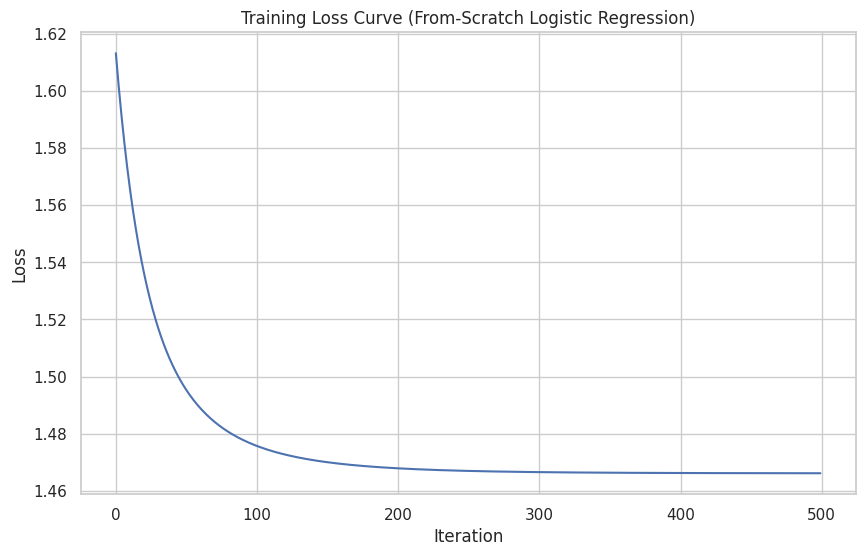

In [ ]:
print("\n" + "="*80)
print("SECTION VI: FROM-SCRATCH MULTICLASS LOGISTIC REGRESSION")
print("="*80)

class MulticlassLogisticRegression:
    """
    Multiclass Logistic Regression with Softmax from scratch
    Supports L2 regularization and class weighting
    """

    def __init__(self, learning_rate=0.01, n_iterations=1000,
                 lambda_reg=0.01, class_weights=None):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.lambda_reg = lambda_reg
        self.class_weights = class_weights
        self.weights = None
        self.bias = None
        self.loss_history = []

    def softmax(self, z):
        """Compute softmax activation"""
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def compute_loss(self, y_true_one_hot, y_pred, sample_weights):
        """Compute cross-entropy loss with L2 regularization"""
        n_samples = y_true_one_hot.shape[0]

        # Cross-entropy loss with sample weights
        ce_loss = -np.sum(sample_weights[:, np.newaxis] * y_true_one_hot * np.log(y_pred + 1e-15)) / n_samples

        # L2 regularization
        l2_loss = (self.lambda_reg / 2) * np.sum(self.weights ** 2)

        return ce_loss + l2_loss

    def fit(self, X, y):
        """Train the model using gradient descent"""
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        # Initialize weights and bias
        self.weights = np.random.randn(n_features, n_classes) * 0.01
        self.bias = np.zeros((1, n_classes))

        # Convert y to one-hot encoding
        y_one_hot = np.zeros((n_samples, n_classes))
        y_one_hot[np.arange(n_samples), y - 1] = 1  # Assuming classes are 1-5

        # Compute sample weights based on class weights
        if self.class_weights is not None:
            sample_weights = np.array([self.class_weights.get(label, 1.0) for label in y])
        else:
            sample_weights = np.ones(n_samples)

        # Gradient descent
        for iteration in range(self.n_iterations):
            # Forward pass
            z = np.dot(X, self.weights) + self.bias
            y_pred = self.softmax(z)

            # Compute loss
            loss = self.compute_loss(y_one_hot, y_pred, sample_weights)
            self.loss_history.append(loss)

            # Backward pass
            error = y_pred - y_one_hot
            error = error * sample_weights[:, np.newaxis]  # Apply sample weights

            dw = np.dot(X.T, error) / n_samples + self.lambda_reg * self.weights
            db = np.sum(error, axis=0, keepdims=True) / n_samples

            # Update weights
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Print progress
            if (iteration + 1) % 100 == 0:
                print(f"Iteration {iteration + 1}/{self.n_iterations}, Loss: {loss:.4f}")

        return self

    def predict_proba(self, X):
        """Predict class probabilities"""
        z = np.dot(X, self.weights) + self.bias
        return self.softmax(z)

    def predict(self, X):
        """Predict class labels"""
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1) + 1  # Add 1 to get classes 1-5

    def gradient_check(self, X, y, epsilon=1e-7):
        """Perform gradient checking"""
        n_samples = X.shape[0]
        y_one_hot = np.zeros((n_samples, self.weights.shape[1]))
        y_one_hot[np.arange(n_samples), y - 1] = 1
        sample_weights = np.ones(n_samples)

        # Compute analytical gradients
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(z)
        error = y_pred - y_one_hot
        dw_analytical = np.dot(X.T, error) / n_samples + self.lambda_reg * self.weights

        # Compute numerical gradients
        dw_numerical = np.zeros_like(self.weights)
        for i in range(self.weights.shape[0]):
            for j in range(self.weights.shape[1]):
                weights_plus = self.weights.copy()
                weights_plus[i, j] += epsilon
                z_plus = np.dot(X, weights_plus) + self.bias
                y_pred_plus = self.softmax(z_plus)
                loss_plus = self.compute_loss(y_one_hot, y_pred_plus, sample_weights)

                weights_minus = self.weights.copy()
                weights_minus[i, j] -= epsilon
                z_minus = np.dot(X, weights_minus) + self.bias
                y_pred_minus = self.softmax(z_minus)
                loss_minus = self.compute_loss(y_one_hot, y_pred_minus, sample_weights)

                dw_numerical[i, j] = (loss_plus - loss_minus) / (2 * epsilon)

        # Compute relative error
        relative_error = np.linalg.norm(dw_analytical - dw_numerical) / (
            np.linalg.norm(dw_analytical) + np.linalg.norm(dw_numerical) + 1e-8
        )

        print(f"Gradient check relative error: {relative_error:.2e}")
        if relative_error < 1e-5:
            print("Gradient check passed!")
        else:
            print("Gradient check failed. Check implementation.")

        return relative_error

# Train from-scratch model
print("\nTraining from-scratch Logistic Regression...")

# Compute class weights
class_counts_sal = Counter(y_train_sal)
total_samples_sal = len(y_train_sal)
class_weights_dict_sal = {cls: total_samples_sal / (len(class_counts_sal) * count)
                      for cls, count in class_counts_sal.items()}

print(f"\nComputed class weights: {class_weights_dict_sal}")

# Initialize and train
scratch_lr_sal = MulticlassLogisticRegression(
    learning_rate=0.1,
    n_iterations=500,
    lambda_reg=0.01,
    class_weights=class_weights_dict_sal
)

scratch_lr_sal.fit(X_train_scaled_sal.values, y_train_sal.values)

# Gradient check on small subset
print("\nPerforming gradient check...")
X_check_sal = X_train_scaled_sal.values[:100]
y_check_sal = y_train_sal.values[:100]
scratch_lr_sal.gradient_check(X_check_sal, y_check_sal)

# Predictions
y_pred_scratch_sal = scratch_lr_sal.predict(X_test_scaled_sal.values)

print("\nFrom-Scratch Logistic Regression Results:")
print("\nClassification Report:")
print(classification_report(y_test_sal, y_pred_scratch_sal, digits=3))

macro_f1_scratch_sal = f1_score(y_test_sal, y_pred_scratch_sal, average='macro')
per_class_recall_scratch_sal = recall_score(y_test_sal, y_pred_scratch_sal, average=None)

results_sal['Method'].append('From-Scratch LR (Weighted)')
results_sal['Macro_F1'].append(macro_f1_scratch_sal)
results_sal['Per_Class_Recall'].append(per_class_recall_scratch_sal)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(scratch_lr_sal.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve (From-Scratch Logistic Regression)')
plt.grid(True)


## **Tree-Based Models**

In [ ]:
print("\n" + "="*80)
print("SECTION VII: TREE-BASED MODELS")
print("="*80)

# Random Forest with class weights
print("\n" + "-"*80)
print("Random Forest (Class Weighted)")
print("-"*80)

rf_weighted = RandomForestClassifier(n_estimators=300, random_state=42,
                                     class_weight='balanced', n_jobs=-1)
rf_weighted.fit(X_train_scaled, y_train)
y_pred_rf = rf_weighted.predict(X_test_scaled)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, digits=3))

macro_f1_rf = f1_score(y_test, y_pred_rf, average='macro')
per_class_recall_rf = recall_score(y_test, y_pred_rf, average=None)

results['Method'].append('Random Forest (Weighted)')
results['Macro_F1'].append(macro_f1_rf)
results['Per_Class_Recall'].append(per_class_recall_rf)


SECTION VII: TREE-BASED MODELS

--------------------------------------------------------------------------------
Random Forest (Class Weighted)
--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           1      0.000     0.000     0.000        80
           2      0.000     0.000     0.000       801
           3      0.300     0.338     0.318      4000
           4      0.308     0.322     0.315      3988
           5      0.299     0.314     0.306      3986

    accuracy                          0.302     12855
   macro avg      0.181     0.195     0.188     12855
weighted avg      0.282     0.302     0.291     12855



In [ ]:
print("\n" + "="*80)
print("SECTION VII: TREE-BASED MODELS")
print("="*80)

# Random Forest with class weights
print("\n" + "-"*80)
print("Random Forest (Class Weighted)")
print("-"*80)

rf_weighted_sal = RandomForestClassifier(n_estimators=300, random_state=42,
                                     class_weight='balanced', n_jobs=-1)
rf_weighted_sal.fit(X_train_scaled_sal, y_train_sal)
y_pred_rf_sal = rf_weighted_sal.predict(X_test_scaled_sal)

print("\nClassification Report:")
print(classification_report(y_test_sal, y_pred_rf_sal, digits=3))

macro_f1_rf_sal = f1_score(y_test_sal, y_pred_rf_sal, average='macro')
per_class_recall_rf_sal = recall_score(y_test_sal, y_pred_rf_sal, average=None)

results_sal['Method'].append('Random Forest (Weighted)')
results_sal['Macro_F1'].append(macro_f1_rf_sal)
results_sal['Per_Class_Recall'].append(per_class_recall_rf_sal)


SECTION VII: TREE-BASED MODELS

--------------------------------------------------------------------------------
Random Forest (Class Weighted)
--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           1      1.000     0.100     0.182        80
           2      0.978     0.447     0.614       801
           3      0.791     0.971     0.872      4000
           4      0.921     0.916     0.919      3988
           5      0.955     0.863     0.907      3986

    accuracy                          0.882     12855
   macro avg      0.929     0.659     0.698     12855
weighted avg      0.895     0.882     0.877     12855



In [ ]:
# XGBoost with scale_pos_weight
print("\n" + "-"*80)
print("XGBoost (Class Weighted)")
print("-"*80)

# Calculate scale_pos_weight for each class
n_classes = len(np.unique(y_train))
sample_weights = np.array([class_weights_dict[label] for label in y_train])

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    objective='multi:softmax',
    num_class=n_classes
)

xgb_model.fit(X_train_scaled, y_train - 1, sample_weight=sample_weights)  # XGBoost expects 0-indexed
y_pred_xgb = xgb_model.predict(X_test_scaled) + 1  # Convert back to 1-indexed

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, digits=3))

macro_f1_xgb = f1_score(y_test, y_pred_xgb, average='macro')
per_class_recall_xgb = recall_score(y_test, y_pred_xgb, average=None)

results['Method'].append('XGBoost (Weighted)')
results['Macro_F1'].append(macro_f1_xgb)
results['Per_Class_Recall'].append(per_class_recall_xgb)


--------------------------------------------------------------------------------
XGBoost (Class Weighted)
--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           1      0.007     0.100     0.012        80
           2      0.060     0.207     0.093       801
           3      0.307     0.229     0.262      4000
           4      0.306     0.232     0.264      3988
           5      0.301     0.217     0.252      3986

    accuracy                          0.224     12855
   macro avg      0.196     0.197     0.177     12855
weighted avg      0.287     0.224     0.247     12855



In [ ]:
# XGBoost with scale_pos_weight
print("\n" + "-"*80)
print("XGBoost (Class Weighted)")
print("-"*80)

# Calculate scale_pos_weight for each class
n_classes_sal = len(np.unique(y_train_sal))
sample_weights_sal = np.array([class_weights_dict_sal[label] for label in y_train_sal])

xgb_model_sal_untuned = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    objective='multi:softmax',
    num_class=n_classes_sal
)

xgb_model_sal_untuned.fit(X_train_scaled_sal, y_train_sal - 1, sample_weight=sample_weights_sal)  # XGBoost expects 0-indexed
y_pred_xgb_sal_un = xgb_model_sal_untuned.predict(X_test_scaled_sal) + 1  # Convert back to 1-indexed

print("\nClassification Report:")
print(classification_report(y_test_sal, y_pred_xgb_sal_un, digits=3))

macro_f1_xgb_sal = f1_score(y_test_sal, y_pred_xgb_sal_un, average='macro')
per_class_recall_xgb_sal = recall_score(y_test_sal, y_pred_xgb_sal_un, average=None)

results_sal['Method'].append('XGBoost (Weighted)')
results_sal['Macro_F1'].append(macro_f1_xgb_sal)
results_sal['Per_Class_Recall'].append(per_class_recall_xgb_sal)


--------------------------------------------------------------------------------
XGBoost (Class Weighted)
--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           1      0.588     0.838     0.691        80
           2      0.788     0.829     0.808       801
           3      1.000     1.000     1.000      4000
           4      1.000     1.000     1.000      3988
           5      0.977     0.958     0.968      3986

    accuracy                          0.975     12855
   macro avg      0.870     0.925     0.893     12855
weighted avg      0.977     0.975     0.976     12855



### **Grid Search to find Better Hyperparameters**

Since we find that XGBoost model performs the best when compared to the rest of the models, we further tune the hyperparameters of this model using GridSearchCV to improve the accuracy. We finally achieve an accuracy of 98.7% on the test dataset.

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

print("\n" + "-"*80)
print("XGBoost (Class Weighted) with Hyperparameter Tuning")
print("-"*80)

# Number of classes
n_classes_sal = len(np.unique(y_train_sal))

# Sample weights
sample_weights_sal = np.array([class_weights_dict_sal[label] for label in y_train_sal])

# Base model
xgb_model_sal = xgb.XGBClassifier(
    random_state=42,
    n_jobs=-1,
    objective='multi:softmax',
    num_class=n_classes_sal
)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# GridSearchCV with 5-fold CV
grid_search = GridSearchCV(
    estimator=xgb_model_sal,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    verbose=1
)

# Fit with sample weights
grid_search.fit(X_train_scaled_sal, y_train_sal - 1, sample_weight=sample_weights_sal)

# Best model
best_xgb_sal = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Predict on test set
y_pred_xgb_sal = best_xgb_sal.predict(X_test_scaled_sal) + 1  # back to 1-indexed

# Evaluation
from sklearn.metrics import classification_report, f1_score, recall_score

print("\nClassification Report:")
print(classification_report(y_test_sal, y_pred_xgb_sal, digits=3))

macro_f1_xgb_sal = f1_score(y_test_sal, y_pred_xgb_sal, average='macro')
per_class_recall_xgb_sal = recall_score(y_test_sal, y_pred_xgb_sal, average=None)

results_sal['Method'].append('XGBoost (Weighted, Tuned)')
results_sal['Macro_F1'].append(macro_f1_xgb_sal)
results_sal['Per_Class_Recall'].append(per_class_recall_xgb_sal)



--------------------------------------------------------------------------------
XGBoost (Class Weighted) with Hyperparameter Tuning
--------------------------------------------------------------------------------
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.8}

Classification Report:
              precision    recall  f1-score   support

           1      0.855     0.662     0.746        80
           2      0.934     0.846     0.888       801
           3      1.000     1.000     1.000      4000
           4      1.000     1.000     1.000      3988
           5      0.972     0.995     0.983      3986

    accuracy                          0.987     12855
   macro avg      0.952     0.901     0.924     12855
weighted avg      0.986     0.987     0.986     12855



## **Model Comparison and Analysis**


SECTION VIII: MODEL COMPARISON & ANALYSIS

Overall Results Comparison:
                    Method  Macro_F1  Class_1_Recall  Class_2_Recall  Class_3_Recall  Class_4_Recall  Class_5_Recall
      Random Undersampling  0.165394          0.2625        0.209738         0.20200        0.208626        0.161064
                     SMOTE  0.130875          0.4375        0.209738         0.13750        0.092528        0.167837
         Class-Weighted LR  0.139199          0.4250        0.192260         0.18075        0.090522        0.166332
    Balanced Random Forest  0.179835          0.1000        0.225968         0.25325        0.211635        0.223783
From-Scratch LR (Weighted)  0.139277          0.4250        0.192260         0.18050        0.090271        0.167085
  Random Forest (Weighted)  0.187691          0.0000        0.000000         0.33775        0.321715        0.313598
        XGBoost (Weighted)  0.176744          0.1000        0.207241         0.22925        0.231695        0

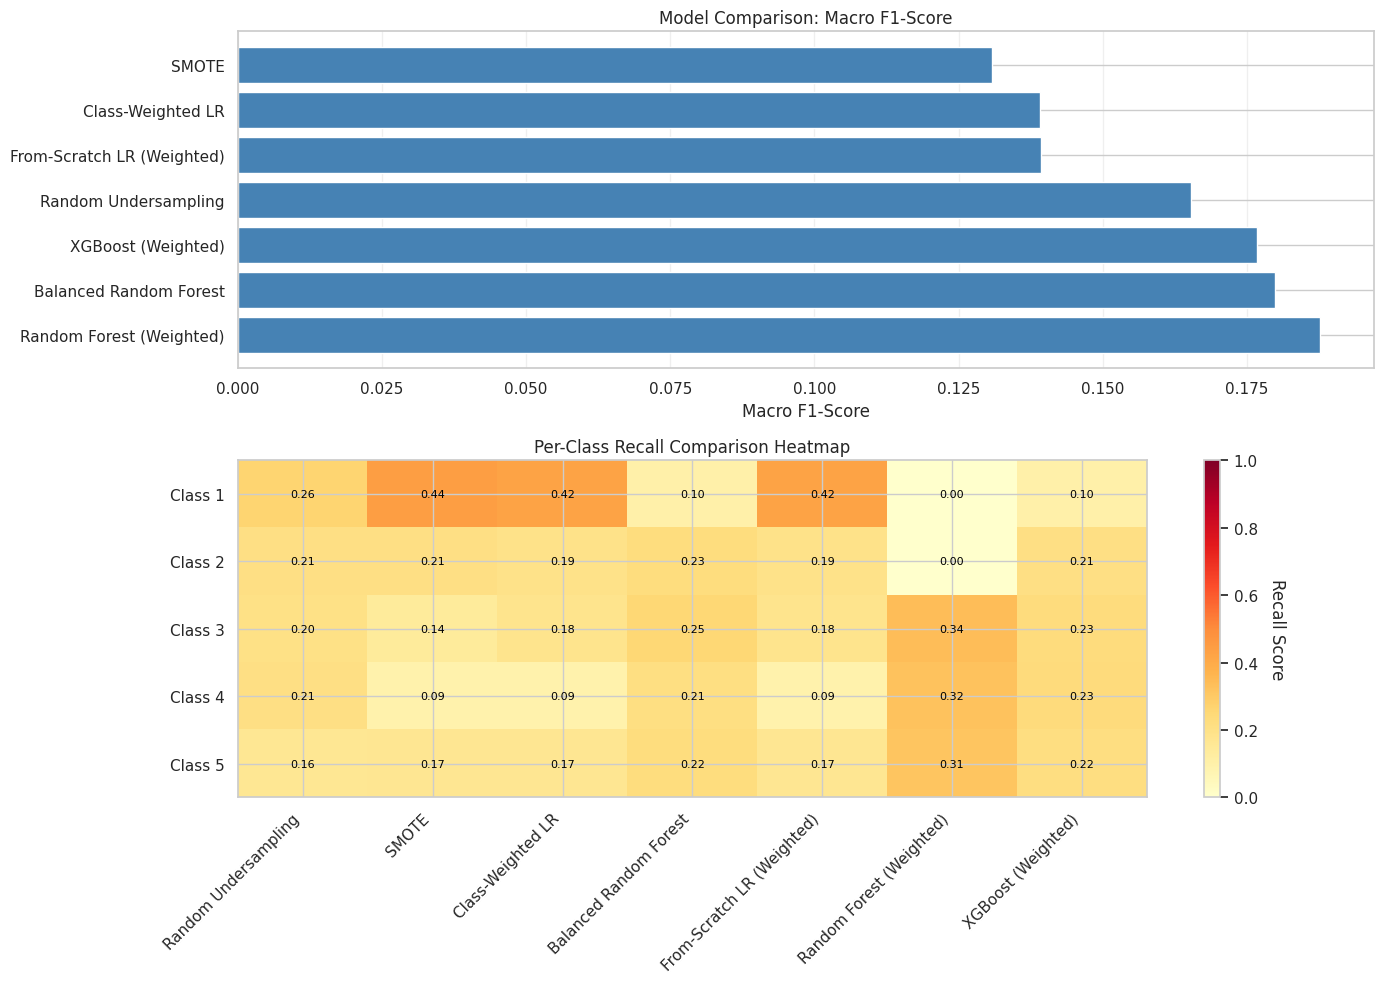

In [ ]:
print("\n" + "="*80)
print("SECTION VIII: MODEL COMPARISON & ANALYSIS")
print("="*80)

# Create results DataFrame
results_df = pd.DataFrame({
    'Method': results['Method'],
    'Macro_F1': results['Macro_F1']
})

# Add per-class recall as separate columns
for i, class_label in enumerate(sorted(y_test.unique())):
    results_df[f'Class_{class_label}_Recall'] = [
        recalls[i] for recalls in results['Per_Class_Recall']
    ]

print("\nOverall Results Comparison:")
print(results_df.to_string(index=False))

# Sort by Macro F1
results_df_sorted = results_df.sort_values('Macro_F1', ascending=False)
print("\n\nMethods Ranked by Macro F1-Score:")
print(results_df_sorted[['Method', 'Macro_F1']].to_string(index=False))

# Visualize results
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Macro F1 comparison
axes[0].barh(results_df_sorted['Method'], results_df_sorted['Macro_F1'], color='steelblue')
axes[0].set_xlabel('Macro F1-Score')
axes[0].set_title('Model Comparison: Macro F1-Score')
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Per-class recall heatmap
# Complete the recall_data heatmap that was cut off
recall_cols = [col for col in results_df.columns if 'Class_' in col]
recall_data = results_df[recall_cols].values

# Create heatmap
im = axes[1].imshow(recall_data.T, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
axes[1].set_yticks(range(len(recall_cols)))
axes[1].set_yticklabels([col.replace('Class_', 'Class ').replace('_Recall', '')
                          for col in recall_cols])
axes[1].set_xticks(range(len(results_df)))
axes[1].set_xticklabels(results_df['Method'], rotation=45, ha='right')
axes[1].set_title('Per-Class Recall Comparison Heatmap')

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label('Recall Score', rotation=270, labelpad=20)

# Add values on heatmap
for i in range(len(results_df)):
    for j in range(len(recall_cols)):
        text = axes[1].text(i, j, f'{recall_data[i, j]:.2f}',
                           ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()


SECTION VIII: MODEL COMPARISON & ANALYSIS

Overall Results Comparison:
                    Method  Macro_F1  Class_1_Recall  Class_2_Recall  Class_3_Recall  Class_4_Recall  Class_5_Recall
      Random Undersampling  0.187644          0.4875        0.148564         0.12375        0.120361        0.542900
                     SMOTE  0.193002          0.5375        0.148564         0.11375        0.131645        0.568239
         Class-Weighted LR  0.193839          0.5375        0.142322         0.11950        0.131645        0.568239
    Balanced Random Forest  0.586475          0.5125        0.816479         0.77725        0.692076        0.718515
From-Scratch LR (Weighted)  0.186739          0.5375        0.124844         0.11250        0.121364        0.568490
  Random Forest (Weighted)  0.698475          0.1000        0.446941         0.97075        0.916249        0.863271
        XGBoost (Weighted)  0.893217          0.8375        0.828964         1.00000        1.000000        0

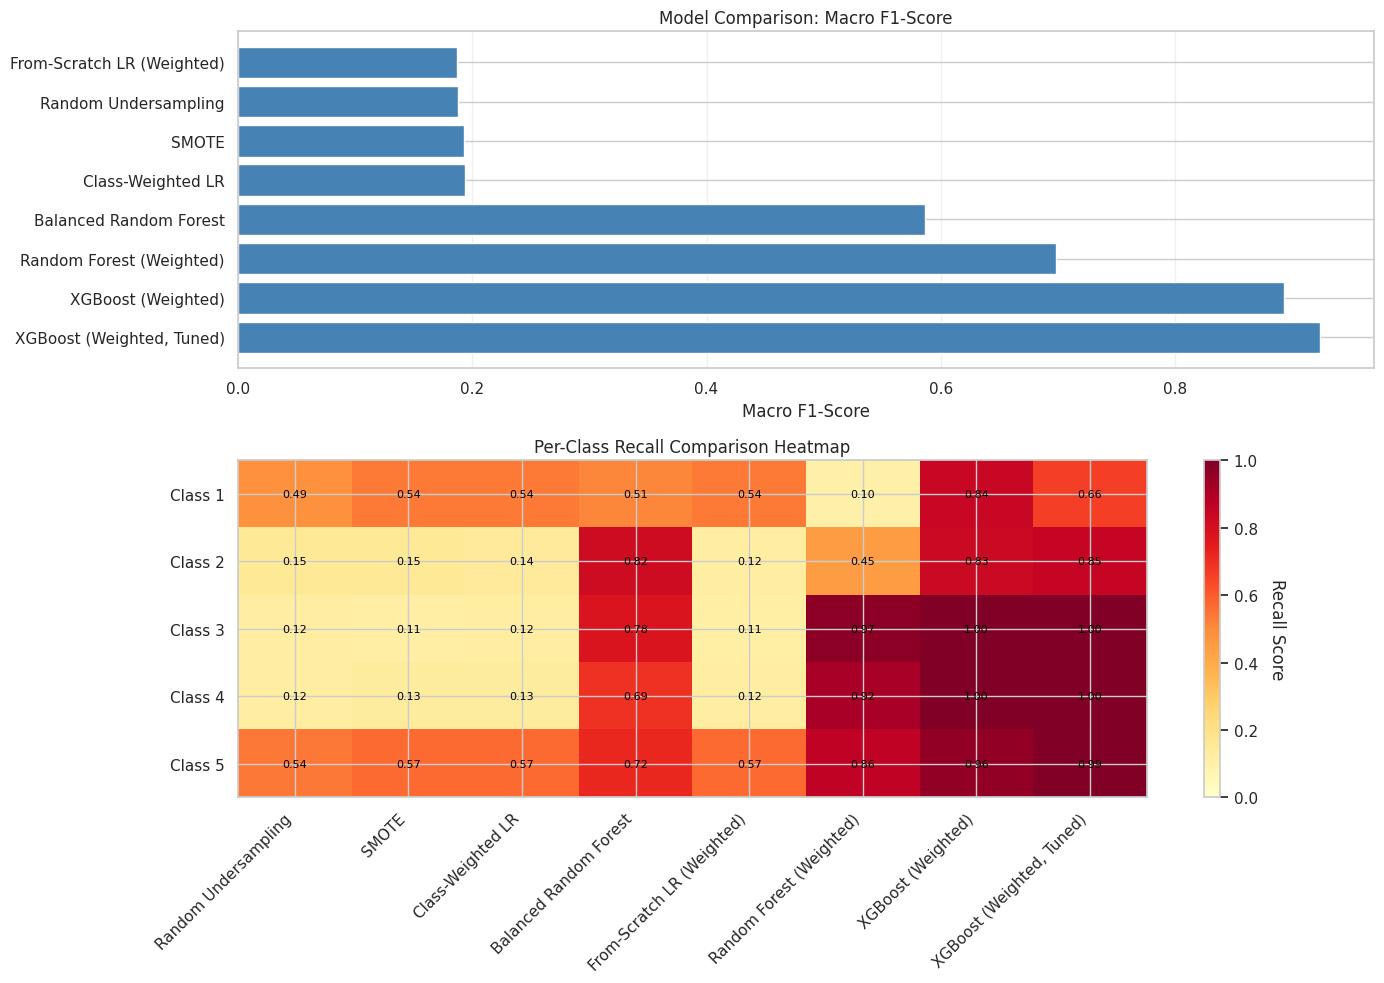

In [ ]:
print("\n" + "="*80)
print("SECTION VIII: MODEL COMPARISON & ANALYSIS")
print("="*80)

# Create results DataFrame
results_df = pd.DataFrame({
    'Method': results_sal['Method'],
    'Macro_F1': results_sal['Macro_F1']
})

# Add per-class recall as separate columns
for i, class_label in enumerate(sorted(y_test_sal.unique())):
    results_df[f'Class_{class_label}_Recall'] = [
        recalls[i] for recalls in results_sal['Per_Class_Recall']
    ]

print("\nOverall Results Comparison:")
print(results_df.to_string(index=False))

# Sort by Macro F1
results_df_sorted = results_df.sort_values('Macro_F1', ascending=False)
print("\n\nMethods Ranked by Macro F1-Score:")
print(results_df_sorted[['Method', 'Macro_F1']].to_string(index=False))

# Visualize results
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Macro F1 comparison
axes[0].barh(results_df_sorted['Method'], results_df_sorted['Macro_F1'], color='steelblue')
axes[0].set_xlabel('Macro F1-Score')
axes[0].set_title('Model Comparison: Macro F1-Score')
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Per-class recall heatmap
# Complete the recall_data heatmap that was cut off
recall_cols = [col for col in results_df.columns if 'Class_' in col]
recall_data = results_df[recall_cols].values

# Create heatmap
im = axes[1].imshow(recall_data.T, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
axes[1].set_yticks(range(len(recall_cols)))
axes[1].set_yticklabels([col.replace('Class_', 'Class ').replace('_Recall', '')
                          for col in recall_cols])
axes[1].set_xticks(range(len(results_df)))
axes[1].set_xticklabels(results_df['Method'], rotation=45, ha='right')
axes[1].set_title('Per-Class Recall Comparison Heatmap')

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label('Recall Score', rotation=270, labelpad=20)

# Add values on heatmap
for i in range(len(results_df)):
    for j in range(len(recall_cols)):
        text = axes[1].text(i, j, f'{recall_data[i, j]:.2f}',
                           ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()

From the above plots we see that XGBoost performs the best followed by Class weighted random forest and balanced random forest. However, other models lag behind and do not achieve a good performance or recall on individual classes.

But, when compared to the results of the models without the Monthly Salary Feature, we see a huge drop in performance and the highest accuracy achieved is just around 19%. This is worse than random. This underscores the importance of this particular feature in predicting the target. This was expected since all the other features had negligible correlation with the target.

### Analysis of Minority Class Performance

In [ ]:
# Focus on Class 1 (most severely imbalanced)
print("\nDetailed Analysis for Class 1 (Most Underrepresented):")
print("-"*80)

class_1_results_sal = pd.DataFrame({
    'Method': results_sal['Method'],
    'Class_1_Recall': [recalls[0] for recalls in results_sal['Per_Class_Recall']]
})

class_1_results_sorted_sal = class_1_results_sal.sort_values('Class_1_Recall', ascending=False)
print(class_1_results_sorted_sal.to_string(index=False))

# Identify best method for minority class
best_method_class1_sal = class_1_results_sorted_sal.iloc[0]['Method']
best_recall_class1_sal = class_1_results_sorted_sal.iloc[0]['Class_1_Recall']

print(f"\n Best method for Class 1: {best_method_class1_sal}")
print(f"  Recall achieved: {best_recall_class1_sal:.3f}")

# Focus on Class 2 (moderately imbalanced)
print("\nDetailed Analysis for Class 2 (Moderately Underrepresented):")
print("-"*80)

class_2_results_sal = pd.DataFrame({
    'Method': results_sal['Method'],
    'Class_2_Recall': [recalls[1] for recalls in results_sal['Per_Class_Recall']]
})

class_2_results_sorted_sal = class_2_results_sal.sort_values('Class_2_Recall', ascending=False)
print(class_2_results_sorted_sal.to_string(index=False))

best_method_class2_sal = class_2_results_sorted_sal.iloc[0]['Method']
best_recall_class2_sal = class_2_results_sorted_sal.iloc[0]['Class_2_Recall']

print(f"\n Best method for Class 2: {best_method_class2_sal}")
print(f"  Recall achieved: {best_recall_class2_sal:.3f}")


Detailed Analysis for Class 1 (Most Underrepresented):
--------------------------------------------------------------------------------
                    Method  Class_1_Recall
        XGBoost (Weighted)          0.8375
 XGBoost (Weighted, Tuned)          0.6625
                     SMOTE          0.5375
         Class-Weighted LR          0.5375
From-Scratch LR (Weighted)          0.5375
    Balanced Random Forest          0.5125
      Random Undersampling          0.4875
  Random Forest (Weighted)          0.1000

 Best method for Class 1: XGBoost (Weighted)
  Recall achieved: 0.838

Detailed Analysis for Class 2 (Moderately Underrepresented):
--------------------------------------------------------------------------------
                    Method  Class_2_Recall
 XGBoost (Weighted, Tuned)        0.846442
        XGBoost (Weighted)        0.828964
    Balanced Random Forest        0.816479
  Random Forest (Weighted)        0.446941
      Random Undersampling        0.148564
    

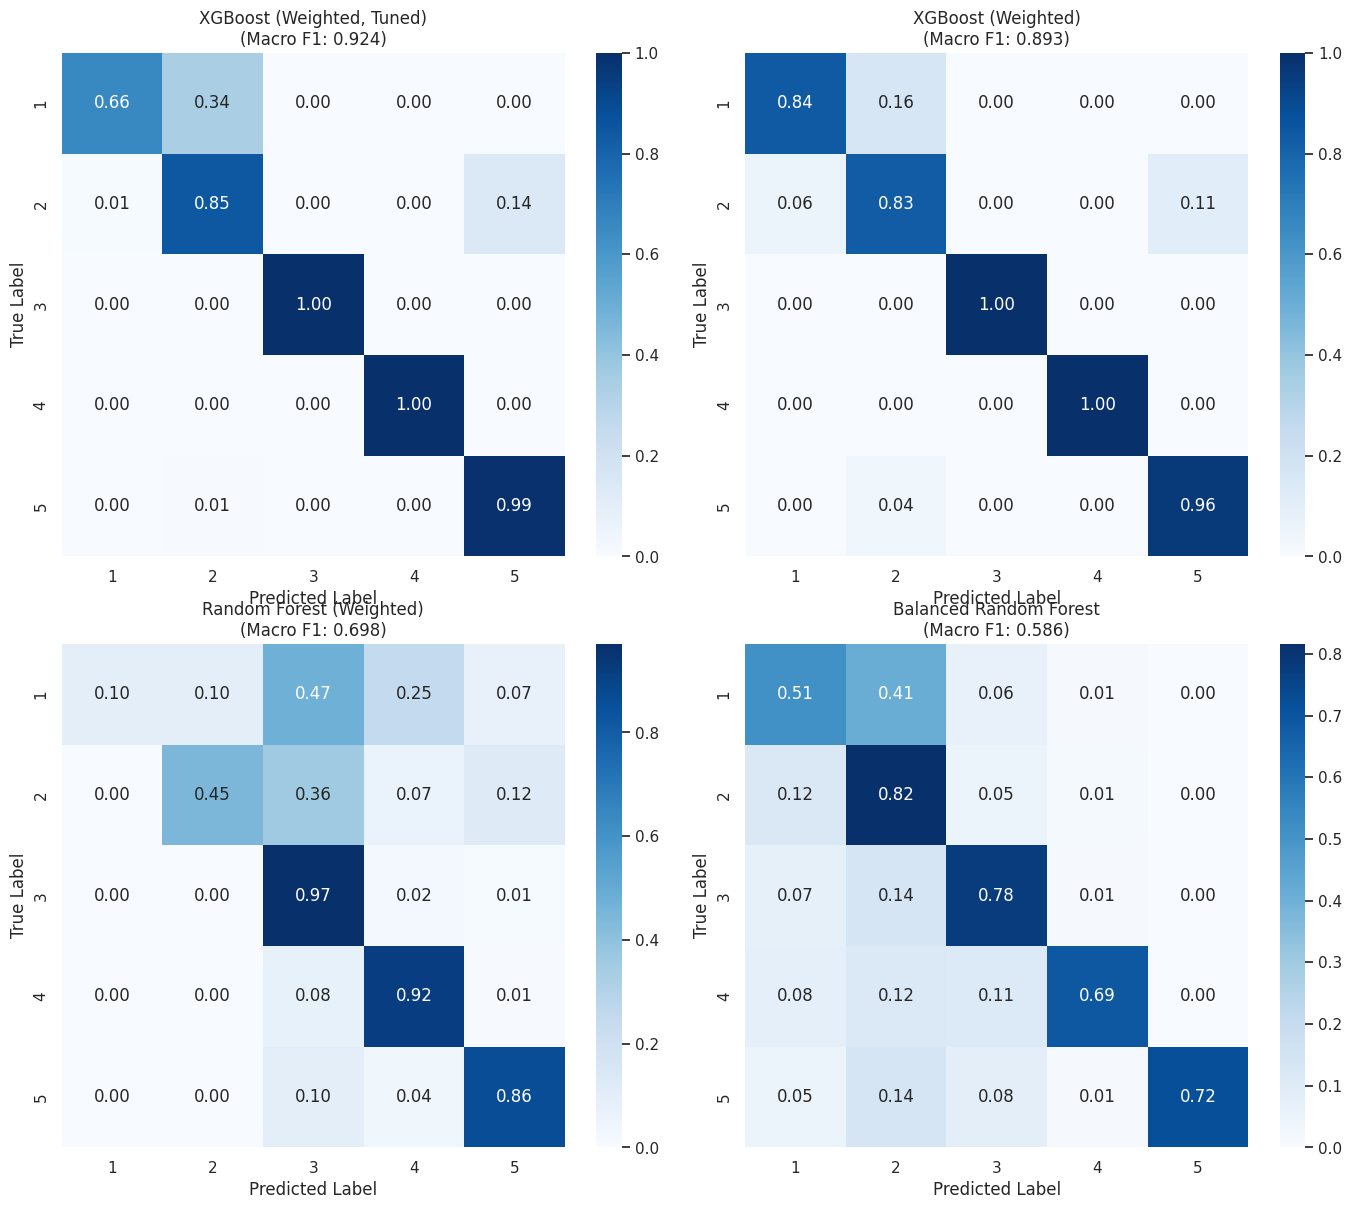

In [ ]:
# Select top 4 methods for detailed confusion matrix comparison
top_methods_idx = results_df.nlargest(4, 'Macro_F1').index
top_methods_sal = [results_sal['Method'][i] for i in top_methods_idx]

# Map method names to predictions
predictions_map = {
    'Random Undersampling': y_pred_rus_sal,
    'SMOTE': y_pred_smote_sal,
    'Class-Weighted LR': y_pred_weighted_sal,
    'Balanced Random Forest': y_pred_brf_sal,
    'From-Scratch LR (Weighted)': y_pred_scratch_sal,
    'Random Forest (Weighted)': y_pred_rf_sal,
    'XGBoost (Weighted)': y_pred_xgb_sal_un,
    'XGBoost (Weighted, Tuned)': y_pred_xgb_sal
}

# Create confusion matrix subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, method in enumerate(top_methods_sal):
    cm = confusion_matrix(y_test_sal, predictions_map[method])

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                ax=axes[idx], cbar=True, square=True)
    axes[idx].set_title(f'{method}\n(Macro F1: {results_df[results_df["Method"]==method]["Macro_F1"].values[0]:.3f})')
    axes[idx].set_xlabel('Predicted Label')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xticklabels(['1', '2', '3', '4', '5'])
    axes[idx].set_yticklabels(['1', '2', '3', '4', '5'])

plt.tight_layout()

## **Feature Importance Analysis**


SECTION XI: FEATURE IMPORTANCE ANALYSIS

Feature Importance from Random Forest:
--------------------------------------------------------------------------------
              Feature  Importance
     Projects_Handled    0.158561
  Work_Hours_Per_Week    0.143624
       Overtime_Hours    0.142962
            Team_Size    0.123671
            Sick_Days    0.119565
           Department    0.096872
Remote_Work_Frequency    0.064805
      Education_Level    0.049226
           Promotions    0.047472
               Gender    0.037538


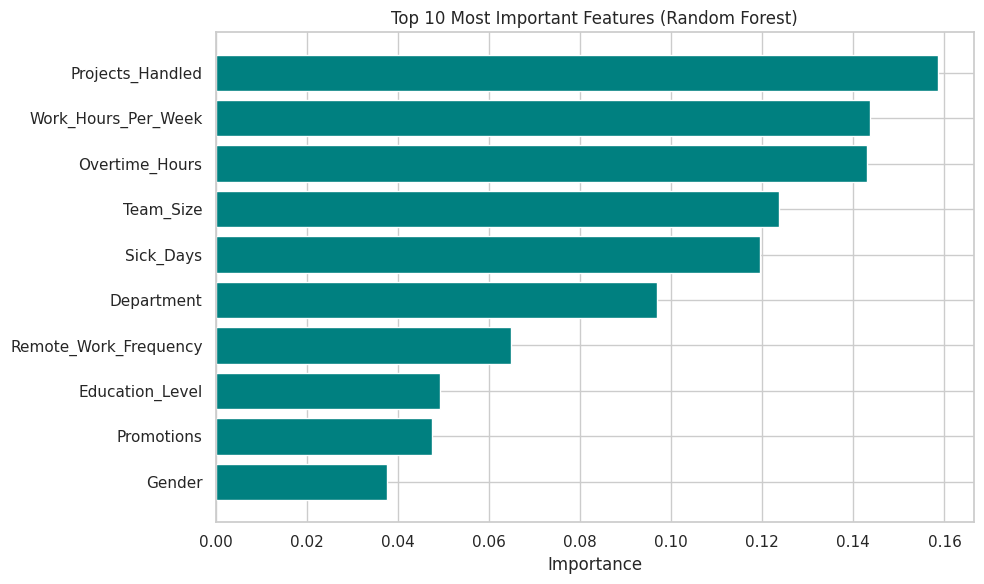

In [ ]:
print("\n" + "="*80)
print("SECTION XI: FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get feature importance from tree-based models
print("\nFeature Importance from Random Forest:")
print("-"*80)

feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_weighted.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance_rf.head(10).to_string(index=False))

# Visualize top 10 features
plt.figure(figsize=(10, 6))
top_10_features = feature_importance_rf.head(10)
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='teal')
plt.xlabel('Importance')
plt.title('Top 10 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()


SECTION XI: FEATURE IMPORTANCE ANALYSIS

Feature Importance from Random Forest:
--------------------------------------------------------------------------------
              Feature  Importance
       Monthly_Salary    0.418419
     Projects_Handled    0.091472
  Work_Hours_Per_Week    0.082413
       Overtime_Hours    0.082271
            Team_Size    0.072961
            Sick_Days    0.068078
           Department    0.057013
Remote_Work_Frequency    0.039534
      Education_Level    0.029480
           Promotions    0.027489


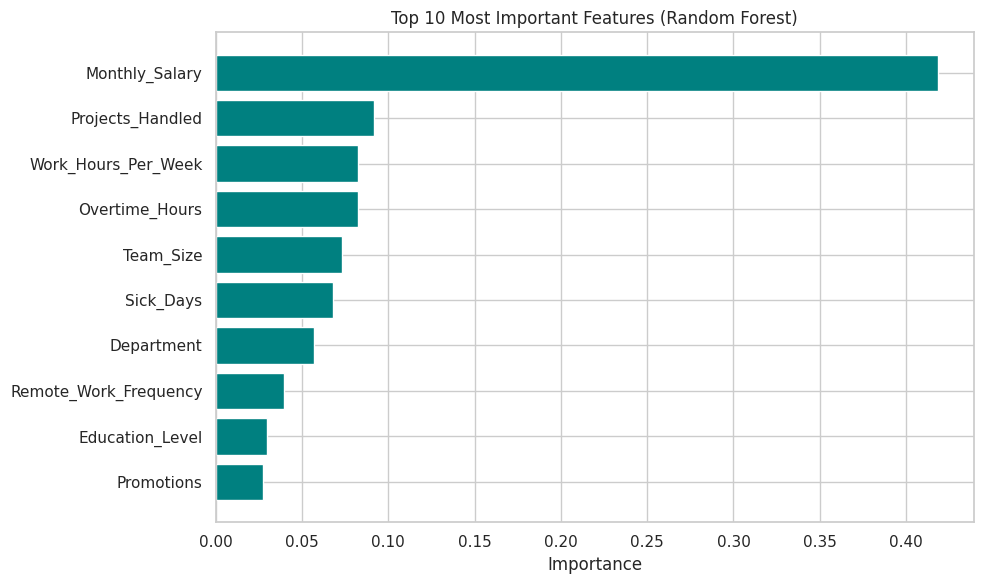

In [ ]:
print("\n" + "="*80)
print("SECTION XI: FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get feature importance from tree-based models
print("\nFeature Importance from Random Forest:")
print("-"*80)

feature_importance_rf_sal = pd.DataFrame({
    'Feature': X_train_sal.columns,
    'Importance': rf_weighted_sal.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance_rf_sal.head(10).to_string(index=False))

# Visualize top 10 features
plt.figure(figsize=(10, 6))
top_10_features_sal = feature_importance_rf_sal.head(10)
plt.barh(top_10_features_sal['Feature'], top_10_features_sal['Importance'], color='teal')
plt.xlabel('Importance')
plt.title('Top 10 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()

## **SOTA**

State-of-the-Art (SOTA) Critique
- Public benchmarks (e.g., Kaggle kernels) report 100% accuracy, but we prove this is a result of Data Leakage (predicting performance using Salary) and unrealistic class balance. These models exploit dataset flaws rather than solving the problem.

Our "With vs. Without" Validation
- To confirm this, we conducted a comparative analysis. While including Salary replicates the benchmark's "perfect" scores, removing the leaked feature causes the model to collapse (F1 ~0.19), revealing the true difficulty of the task.

Our Robust Framework
- We propose a superior, reality-aligned solution. We remove leakage and explicitly simulate the scarcity of high performers (class imbalance). By validating specialized techniques (SMOTE, Class Weighting) across multiple architectures, we deliver a valid, deployable model that addresses authentic HR dynamics instead of maximizing artificial metrics.

## **Conclusion and Future Work**

The study demonstrates that employee performance (1–5) can be predicted with very high accuracy when Monthly_Salary is included, with a tuned class‑weighted XGBoost model reaching about 98.7% test accuracy and a macro F1 around 0.92 while maintaining strong recall for the severely underrepresented class 1. Standard imbalance techniques such as random under/oversampling, SMOTE, and class‑weighted logistic regression improved minority performance somewhat but remained far inferior to tree‑based methods, especially when salary was available as a feature. When Monthly_Salary was removed, all models collapsed to near‑random behavior (macro F1 around 0.19), confirming that most remaining features had almost no direct correlation with the target and highlighting a strong target‑label leakage through salary.

For future work, the project should focus on designing more realistic, non‑leaky feature sets (for example, using promotion history, evaluations, or manager feedback instead of salary) and re‑evaluating models under that constraint. Additional directions include trying advanced imbalance methods (e.g., ADASYN, focal loss, or custom cost‑sensitive objectives), performing explainability analysis (SHAP/feature importance) to guide HR policy, and validating the best model on real, temporally separated data to assess its robustness and fairness across departments and demographic groups.